In [ ]:
# from pybaseball import playerid_reverse_lookup, player_search_list
from helper import split_name, calc_fantasy_points_batting, calc_fantasy_points_pitching, get_value_before_comma
from read_data import cast_feature_dtypes, pull_data, pull_projections
from modeling import split_data, create_baseline, tune_xgb, create_model, compile_predictions, combine_projections
from data_viz import plot_actual_vs_pred_mlb, plot_resid_vs_pred_mlb, plot_resid_hist_mlb, plot_decile_calib
from clean_and_cluster import assign_position_group, calculate_relative_value, determine_optimal_k, segment_players
from config import AGG_YEARS, batting_stat_cols, pitching_stat_cols, batting_agg_cols, pitching_agg_cols, POS_DAMPENING_MAP
from hyperopt import hp
from xgboost import plot_importance
from IPython.display import display
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from datetime import datetime

START_YEAR = 2005 # <- Beginning season for data pull
END_YEAR = 2025 # <- Ending season for data pull, final model will predict following season
MODEL_WEIGHT = 0.67
PROJECTION_WEIGHT = 1 - MODEL_WEIGHT
ROSTER_SIZE = 20
LEAGUE_SIZE = 12
BONUS_PLAYER_POOL_MULT = 1.15
PITCHER_SPLIT = 0.34
BATTER_SPLIT_IF = 0.33
BATTER_SPLIT_OF = 0.33

# URL of the FantasyPros projections page
batting_url = "https://www.fantasypros.com/mlb/projections/hitters.php"
pitching_url = "https://www.fantasypros.com/mlb/projections/pitchers.php"

C:\Users\jorda\Documents\development\baseball_modeling\.venv\Lib\site-packages\hyperopt\atpe.py:19: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources


In [2]:
# Pull data for batters & pitchers
batting_df, pitching_df = pull_data(
    start_year=START_YEAR,
    end_year=END_YEAR,
    agg_years=AGG_YEARS,
    batting_stat_cols=batting_stat_cols,
    pitching_stat_cols=pitching_stat_cols,
    batting_agg_cols=batting_agg_cols,
    pitching_agg_cols=pitching_agg_cols,
    career_window_years=10, # NOTE: as of 2025, career aggregates can only reach back 10 years in a single pull - rule in pybaseball
)

# Casting feature dtypes for batting & pitching dataframes
batting_df = cast_feature_dtypes(batting_df)
pitching_df = cast_feature_dtypes(pitching_df)

# Filtering pitchers from batting_df, they should not be included in the batter model
batting_df = batting_df[batting_df["pos_type"] != "Pitcher"].copy()
# Dropping pos_type and primary_pos from pitching_df as they are redundant (every player is a pitcher)
pitching_df = pitching_df.drop(columns=["pos_type", "primary_pos"]).copy()

# Defining the prediction data for batters & pitchers
batting_pred = batting_df[batting_df["Season"] == END_YEAR].copy()
pitching_pred = pitching_df[pitching_df["Season"] == END_YEAR].copy()
# Dropping the prediction year from the training data
batting_df = batting_df[batting_df["Season"] < END_YEAR].copy()
pitching_df = pitching_df[pitching_df["Season"] < END_YEAR].copy()

# Filter out players with 0 future fantasy points (would not be fantasy draft eligible regardless)
batting_df = batting_df[batting_df["fantasy_points_future"] > 0].copy()
pitching_df = pitching_df[pitching_df["fantasy_points_future"] > 0].copy()

Pulling data for year: 2024
Pulling data for year: 2025
Gathering player lookup table. This may take a moment.
Data saved successfully.
Data pull & feature engineering complete.


In [ ]:
# TODO: Place generate_prediction_intervals into modeling.py script
# TODO: Update process so that calc_fantasy_points functions can be adjusted dynamically based on league settings, maybe calculate both Underdog & DK in read_data and only select relevant one based on inputs to notebook?
# TODO: Code cleanup/organization

# Pulling FantasyPros Projection Data

In [ ]:
batting_projections = pull_projections(batting_url)
# Replace NaN values in the "Positions" column with "DH" for hitters
batting_projections['Positions'] = batting_projections['Positions'].fillna('DH')
# Calculating projected number of singles
batting_projections['1B'] = batting_projections['H'] - batting_projections['2B'] - batting_projections['3B'] - batting_projections['HR']
# Each player will receive 6 projected HBP by default (average number of HBP per season for batters with at least 100 games played)
batting_projections['HBP'] = 6
# Calculating batting fantasy point projection
batting_projections = calc_fantasy_points_batting(batting_projections, 'projected_fantasy_points')
# Selecting relevant columns
batting_projections = batting_projections[['first_name', 'last_name', 'Team', 'Positions', 'projected_fantasy_points']]

pitching_projections = pull_projections(pitching_url)
# Replace NaN values in the "Positions" column with "SP" for pitchers
pitching_projections['Positions'] = pitching_projections['Positions'].fillna('SP')
# Renaming the "K" column to "SO" for pitchers
pitching_projections = pitching_projections.rename(columns={'K': 'SO'})
# Calculating pitching fantasy point projection
pitching_projections = calc_fantasy_points_pitching(pitching_projections, 'projected_fantasy_points')
# Selecting relevant columns
pitching_projections = pitching_projections[['first_name', 'last_name', 'Team', 'Positions', 'projected_fantasy_points']]

# Creating Batting Model

## Creating baseline batting predictions

In [ ]:
# Splitting data
x_train, x_val, x_test, y_train, y_val, y_test = split_data(batting_df, random_state=753)

# Plotting data
model, y_pred = create_baseline(x_train.drop(columns=['IDfg']), x_val.drop(columns=['IDfg']), x_test.drop(columns=['IDfg']), 
                                            y_train, y_val, y_test)

[Test] RMSE: 269.014 | MAE: 210.461 | R^2: 0.618


In [ ]:
batting_comp = compile_predictions(batting_df, x_test, y_test, y_pred)
display(batting_comp)

Name  fantasy_points_future  predicted_fantasy_points  \
246          Juan Soto                 1814.0               1802.129639   
66        Mookie Betts                 1769.0               1781.928833   
793       Alex Bregman                 1772.0               1765.502930   
515   Paul Goldschmidt                 1771.0               1753.577759   
1304     Shohei Ohtani                 2143.0               1738.494995   
...                ...                    ...                       ...   
352     Michael Chavis                  265.0                128.315704   
884     Jose Constanza                  131.0                127.497192   
1519       Brett Hayes                  123.0                113.895386   
1342          Pete Orr                  236.0                105.935089   
630        Pat Valaika                  289.0                 90.649086   

      prediction_diff  absolute_diff  Season  Age  fantasy_points  
246        -11.870361      11.870361    2024   25            1799  
66          12.928833      12.928833    2022   29            1477  
793         -6.497070       6.497070    2018   24            1665  
515        -17.422241      17.422241    2014   26            1143  
1304      -404.505005     404.505005    2023   28            1635  
...               ...            ...     ...  ...             ...  
352       -136.684296     136.684296    2019   23             746  
884         -3.502808       3.502808    2011   27             229  
1519        -9.104614       9.104614    2011   27             255  
1342      -130.064911     130.064911    2005   26             300  
630       -198.350914     198.350914    2019   26             123  

[1590 rows x 8 columns]

# Building Final Model

In [ ]:
space = {
    "learning_rate": hp.loguniform("learning_rate", np.log(0.025), np.log(0.08)),

    # leaf-based complexity control
    "max_leaves": hp.quniform("max_leaves", 8, 80, 1),

    "subsample": hp.uniform("subsample", 0.8, 0.95),
    "colsample_bytree": hp.uniform("colsample_bytree", 0.65, 0.95),

    "min_child_weight": hp.loguniform("min_child_weight", np.log(0.5), np.log(6.0)),
    "reg_lambda": hp.loguniform("reg_lambda", np.log(1e-2), np.log(10.0)),
    "reg_alpha": hp.loguniform("reg_alpha", np.log(1e-3), np.log(10.0)),
    "gamma": hp.loguniform("gamma", np.log(1e-4), np.log(0.5)),
}

In [ ]:
from xgboost import XGBRegressor

def generate_prediction_intervals(
    X_train: pd.DataFrame,
    y_train: pd.Series,
    X_val: pd.DataFrame | None,
    y_val: pd.Series | None,
    X_pred: pd.DataFrame,
    *,
    base_params: dict,
    n_bootstrap: int = 30,
    random_state: int = 62820,
    id_cols: list[str] | None = None,
    n_estimators: int = 5000,
    early_stopping_rounds: int = 50,
) -> pd.DataFrame:
    """
    Estimate prediction intervals via bootstrap-resampled leaf-based XGBoost models.

    Trains n_bootstrap models on random subsamples (with replacement) of X_train/y_train,
    each validated on X_val/y_val. Aggregates predictions across all models to produce
    percentile estimates and upside/downside metrics for draft prioritization.

    Parameters
    ----------
    X_train, y_train
        Training predictors and target (resampled with replacement in each iteration).
    X_val, y_val
        Optional validation set for early stopping. Pass None to disable early stopping.
    X_pred
        Feature frame to generate intervals for. Index and id_cols are preserved in output.
    base_params : dict
        XGBoost hyperparameters from tuning (e.g., best_params from tune_xgb).
        Should include leaf-based settings (grow_policy, max_leaves, learning_rate, etc.).
    n_bootstrap : int, default 30
        Number of bootstrap models to train. Higher = smoother tails, slower runtime.
    random_state : int, default 62820
        Base seed; each bootstrap uses seed + iteration index for reproducibility.
    id_cols : list[str] | None, default ["IDfg"]
        Columns to preserve from X_pred in the returned frame (player identifiers).
    n_estimators, early_stopping_rounds : int
        XGBoost training arguments.

    Returns
    -------
    pd.DataFrame
        Index matches X_pred. Columns:
          - pred_mean: ensemble mean prediction
          - pred_p10, pred_p50, pred_p90: 10th, 50th, 90th percentiles
          - pred_width_80: (p90 - p10); total prediction uncertainty
          - pred_upside: (p90 - mean); expected ceiling gain
          - pred_downside: (mean - p10); expected floor loss
          - implied_upside: upside / downside ratio; >1 = positively skewed (high-ceiling players)
          - plus any id_cols from X_pred

    Notes
    -----
    Use pred_upside to identify breakout candidates; use pred_downside to avoid busts.
    Players with high upside and low downside offer best risk/reward for draft.
    """
    id_cols = id_cols or ["IDfg"]

    def _drop_ids(df: pd.DataFrame) -> pd.DataFrame:
        return df.drop(columns=[c for c in id_cols if c in df.columns], errors="ignore")

    # Prepare feature matrices (drop id cols for training/inference)
    X_tr = _drop_ids(X_train).reset_index(drop=True)
    X_v = _drop_ids(X_val).reset_index(drop=True) if X_val is not None else None
    X_p = _drop_ids(X_pred).reset_index(drop=True)

    # Ensure y indexes align
    y_tr_full = y_train.reset_index(drop=True)
    y_v_full = y_val.reset_index(drop=True) if y_val is not None else None

    preds_list = []

    # Merge base_params with fixed defaults (base_params takes precedence)
    params = {
        "objective": "reg:squarederror",
        "eval_metric": "rmse",
        "tree_method": "hist",
        "enable_categorical": True,
    }
    params.update(base_params or {})

    for b in range(n_bootstrap):
        # Bootstrap indices from training set
        rng_b = np.random.default_rng(random_state + b)
        idx = rng_b.choice(len(X_tr), size=len(X_tr), replace=True)

        model = XGBRegressor(
            n_estimators=n_estimators,
            random_state=random_state + b,
            early_stopping_rounds=early_stopping_rounds,
            n_jobs=-1,
            **params,
        )

        if X_v is not None and y_v_full is not None:
            model.fit(
                X_tr.iloc[idx],
                y_tr_full.iloc[idx],
                eval_set=[(X_v, y_v_full)],
                verbose=False,
            )
        else:
            model.fit(
                X_tr.iloc[idx],
                y_tr_full.iloc[idx],
                verbose=False,
            )

        preds_list.append(model.predict(X_p))

    pred_mat = np.vstack(preds_list)  # shape: (n_bootstrap, n_rows_pred)

    out = pd.DataFrame(
        {
            "pred_mean": pred_mat.mean(axis=0),
            "pred_p10": np.percentile(pred_mat, 10, axis=0),
            "pred_p50": np.percentile(pred_mat, 50, axis=0),
            "pred_p90": np.percentile(pred_mat, 90, axis=0),
        },
        index=X_pred.index,
    )
    
    # Defining a downside_floor for implied upside calculation
    downside_floor = 0.01 * out["pred_mean"].abs().clip(lower=1.0) # 1% of mean

    out["pred_width_80"] = out["pred_p90"] - out["pred_p10"]
    out["pred_upside"] = out["pred_p90"] - out["pred_mean"]
    out["pred_downside"] = out["pred_mean"] - out["pred_p10"]
    out["implied_upside"] = out["pred_upside"] / (out["pred_downside"] + downside_floor)

    # Prepend id columns from original X_pred when available
    id_present = [c for c in id_cols if c in X_pred.columns]
    if id_present:
        ids = X_pred[id_present].reset_index(drop=True)
        out = pd.concat([ids, out.reset_index(drop=True)], axis=1)
        out.index = X_pred.index

    return out

# Batting Predictions

In [ ]:
# Tune model
best_params = tune_xgb(
    X_train=x_train,
    X_val=x_val,
    y_train=y_train,
    y_val=y_val,
    space=space,
    metric="rmse",     
    alpha=1.5,
    evals=50,
    random_state=4202024,
    id_cols=["IDfg"],
    max_depth_choices=None,
)

# Generating prediction intervals via bootstrap-resampled models
batting_intervals = generate_prediction_intervals(
    X_train=x_train,
    y_train=y_train,
    X_val=x_val,
    y_val=y_val,
    X_pred=batting_pred.drop(columns=['fantasy_points_future']),
    base_params=best_params,
    n_bootstrap=25,
    random_state=202404,
    id_cols=['IDfg', 'Name'],
    n_estimators=1000,
    early_stopping_rounds=30,
)

100%|██████████| 50/50 [03:00<00:00,  3.62s/trial, best loss: 251.16808834370784]
Best Parameters: {'learning_rate': 0.028404713391579916, 'max_leaves': 28, 'grow_policy': 'lossguide', 'subsample': 0.9412370773438707, 'colsample_bytree': 0.7126314441314087, 'min_child_weight': 0.7127523666742188, 'reg_lambda': 0.17454863825598102, 'reg_alpha': 0.007985988373595284, 'gamma': 0.005463174357124977}
[Best trial @ val] optimized=rmse | RMSE=251.168 | MAE=195.646 | ASYM=80117.477


In [ ]:
# Create final model
batting_model, y_pred = create_model(
    X_train=x_train,
    X_val=x_val,
    X_test=x_test,
    y_train=y_train,
    y_val=y_val,
    y_test=y_test,
    final_params=best_params,
    random_state=42024,
    id_cols=["IDfg"],
    alpha=1.5,               
)

Best iteration: 419
[Val] RMSE: 252.340 | MAE: 197.168 | R^2: 0.676 | ASYM: 81069.767
[Test] RMSE: 264.916 | MAE: 206.887 | R^2: 0.630 | ASYM: 86953.839


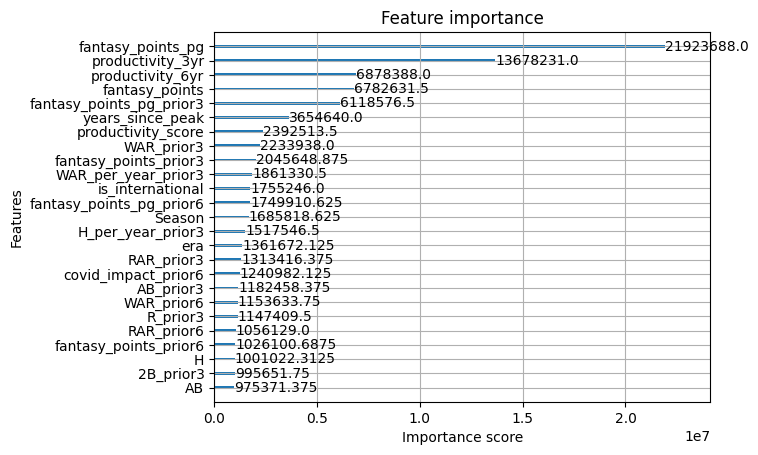

In [ ]:
# Plot feature importance using XGBoost's built-in method
plot_importance(batting_model, importance_type="gain", max_num_features=25)
plt.show()

In [ ]:
batting_results = compile_predictions(batting_df, x_test, y_test, y_pred)
display(batting_results)

Name  fantasy_points_future  predicted_fantasy_points  \
1304     Shohei Ohtani                 2143.0               1771.343506   
246          Juan Soto                 1814.0               1764.660889   
515   Paul Goldschmidt                 1771.0               1706.422974   
1146     Manny Machado                 1597.0               1651.463257   
618      Robinson Cano                 1582.0               1633.699707   
...                ...                    ...                       ...   
658      Phillip Ervin                  119.0                136.318527   
969        Cole Tucker                  215.0                132.510208   
464       Tim Locastro                  187.0                131.228409   
884     Jose Constanza                  131.0                123.378876   
630        Pat Valaika                  289.0                 54.504410   

      prediction_diff  absolute_diff  Season  Age  fantasy_points  
1304      -371.656494     371.656494    2023   28            1635  
246        -49.339111      49.339111    2024   25            1799  
515        -64.577026      64.577026    2014   26            1143  
1146        54.463257      54.463257    2017   24            1365  
618         51.699707      51.699707    2011   28            1559  
...               ...            ...     ...  ...             ...  
658         17.318527      17.318527    2019   26             497  
969        -82.489792      82.489792    2020   23             157  
464        -55.771591      55.771591    2019   26             498  
884         -7.621124       7.621124    2011   27             229  
630       -234.495590     234.495590    2019   26             123  

[1590 rows x 8 columns]

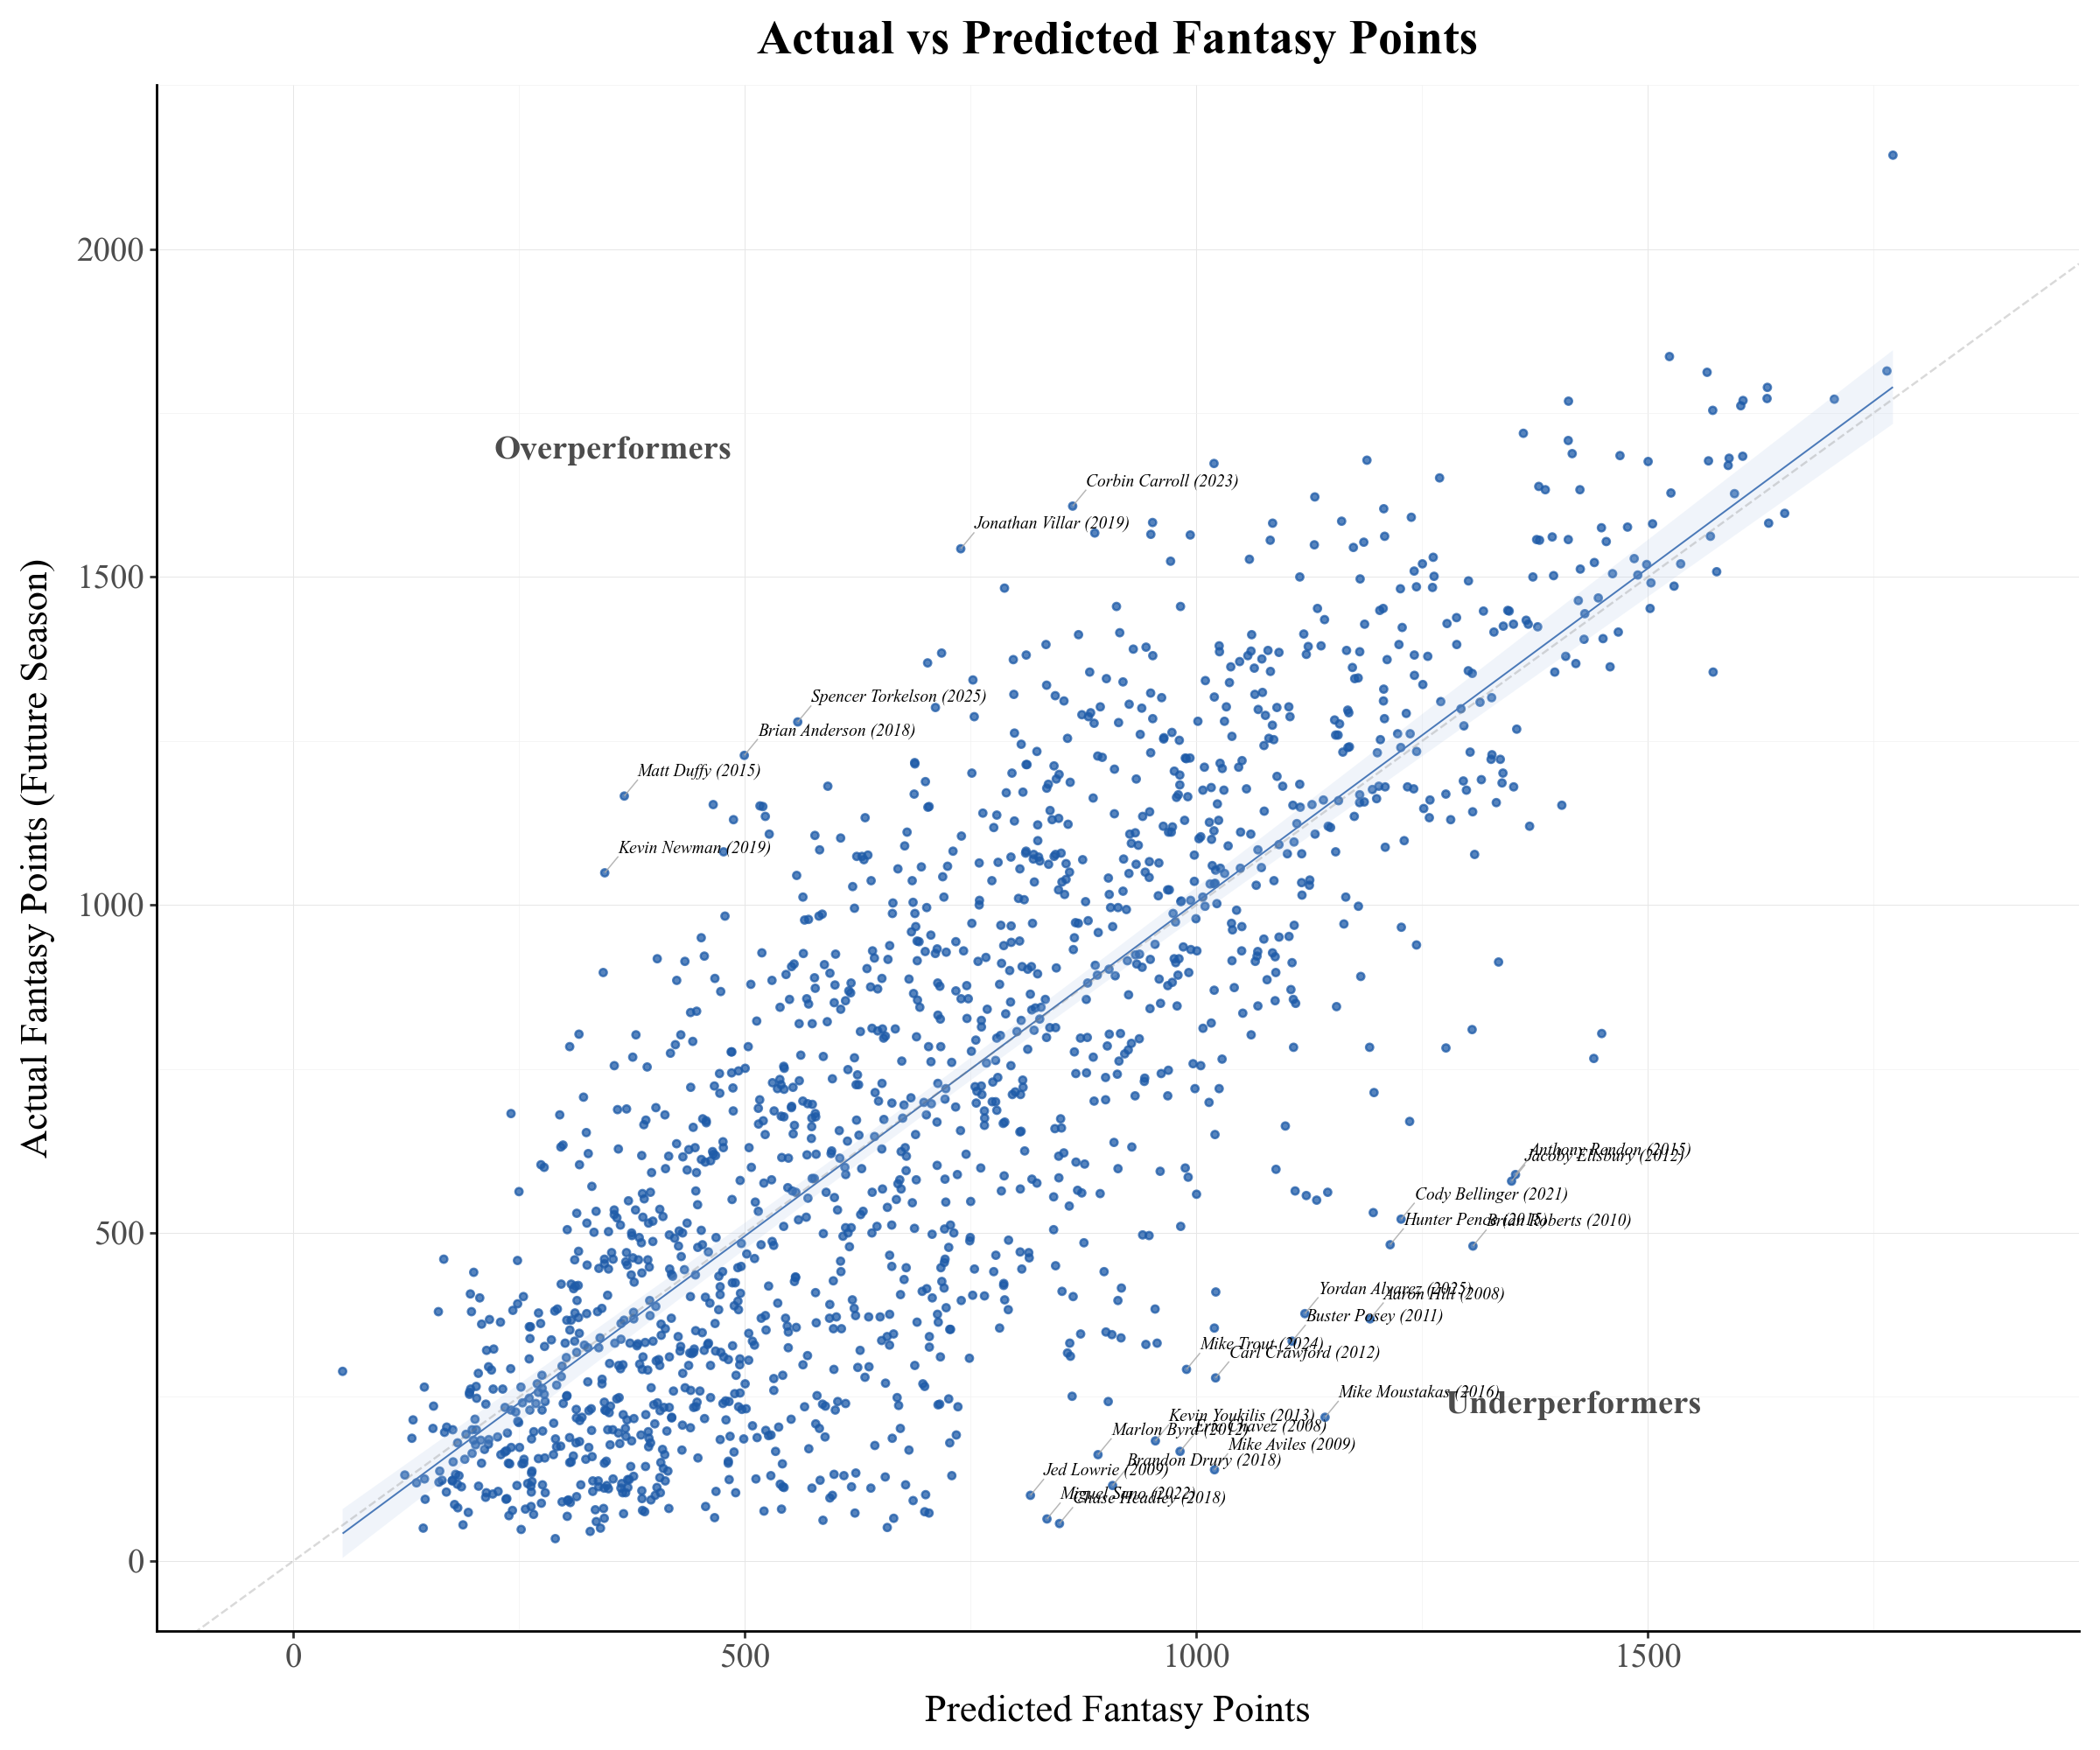

In [ ]:
p1 = plot_actual_vs_pred_mlb(
    batting_results,
    top_n=25,
    x_offset=15,
    y_offset=25,
    add_one_to_season_in_label=True,  # add 1 to season for labels to reflect predicted year
)
p1.show()

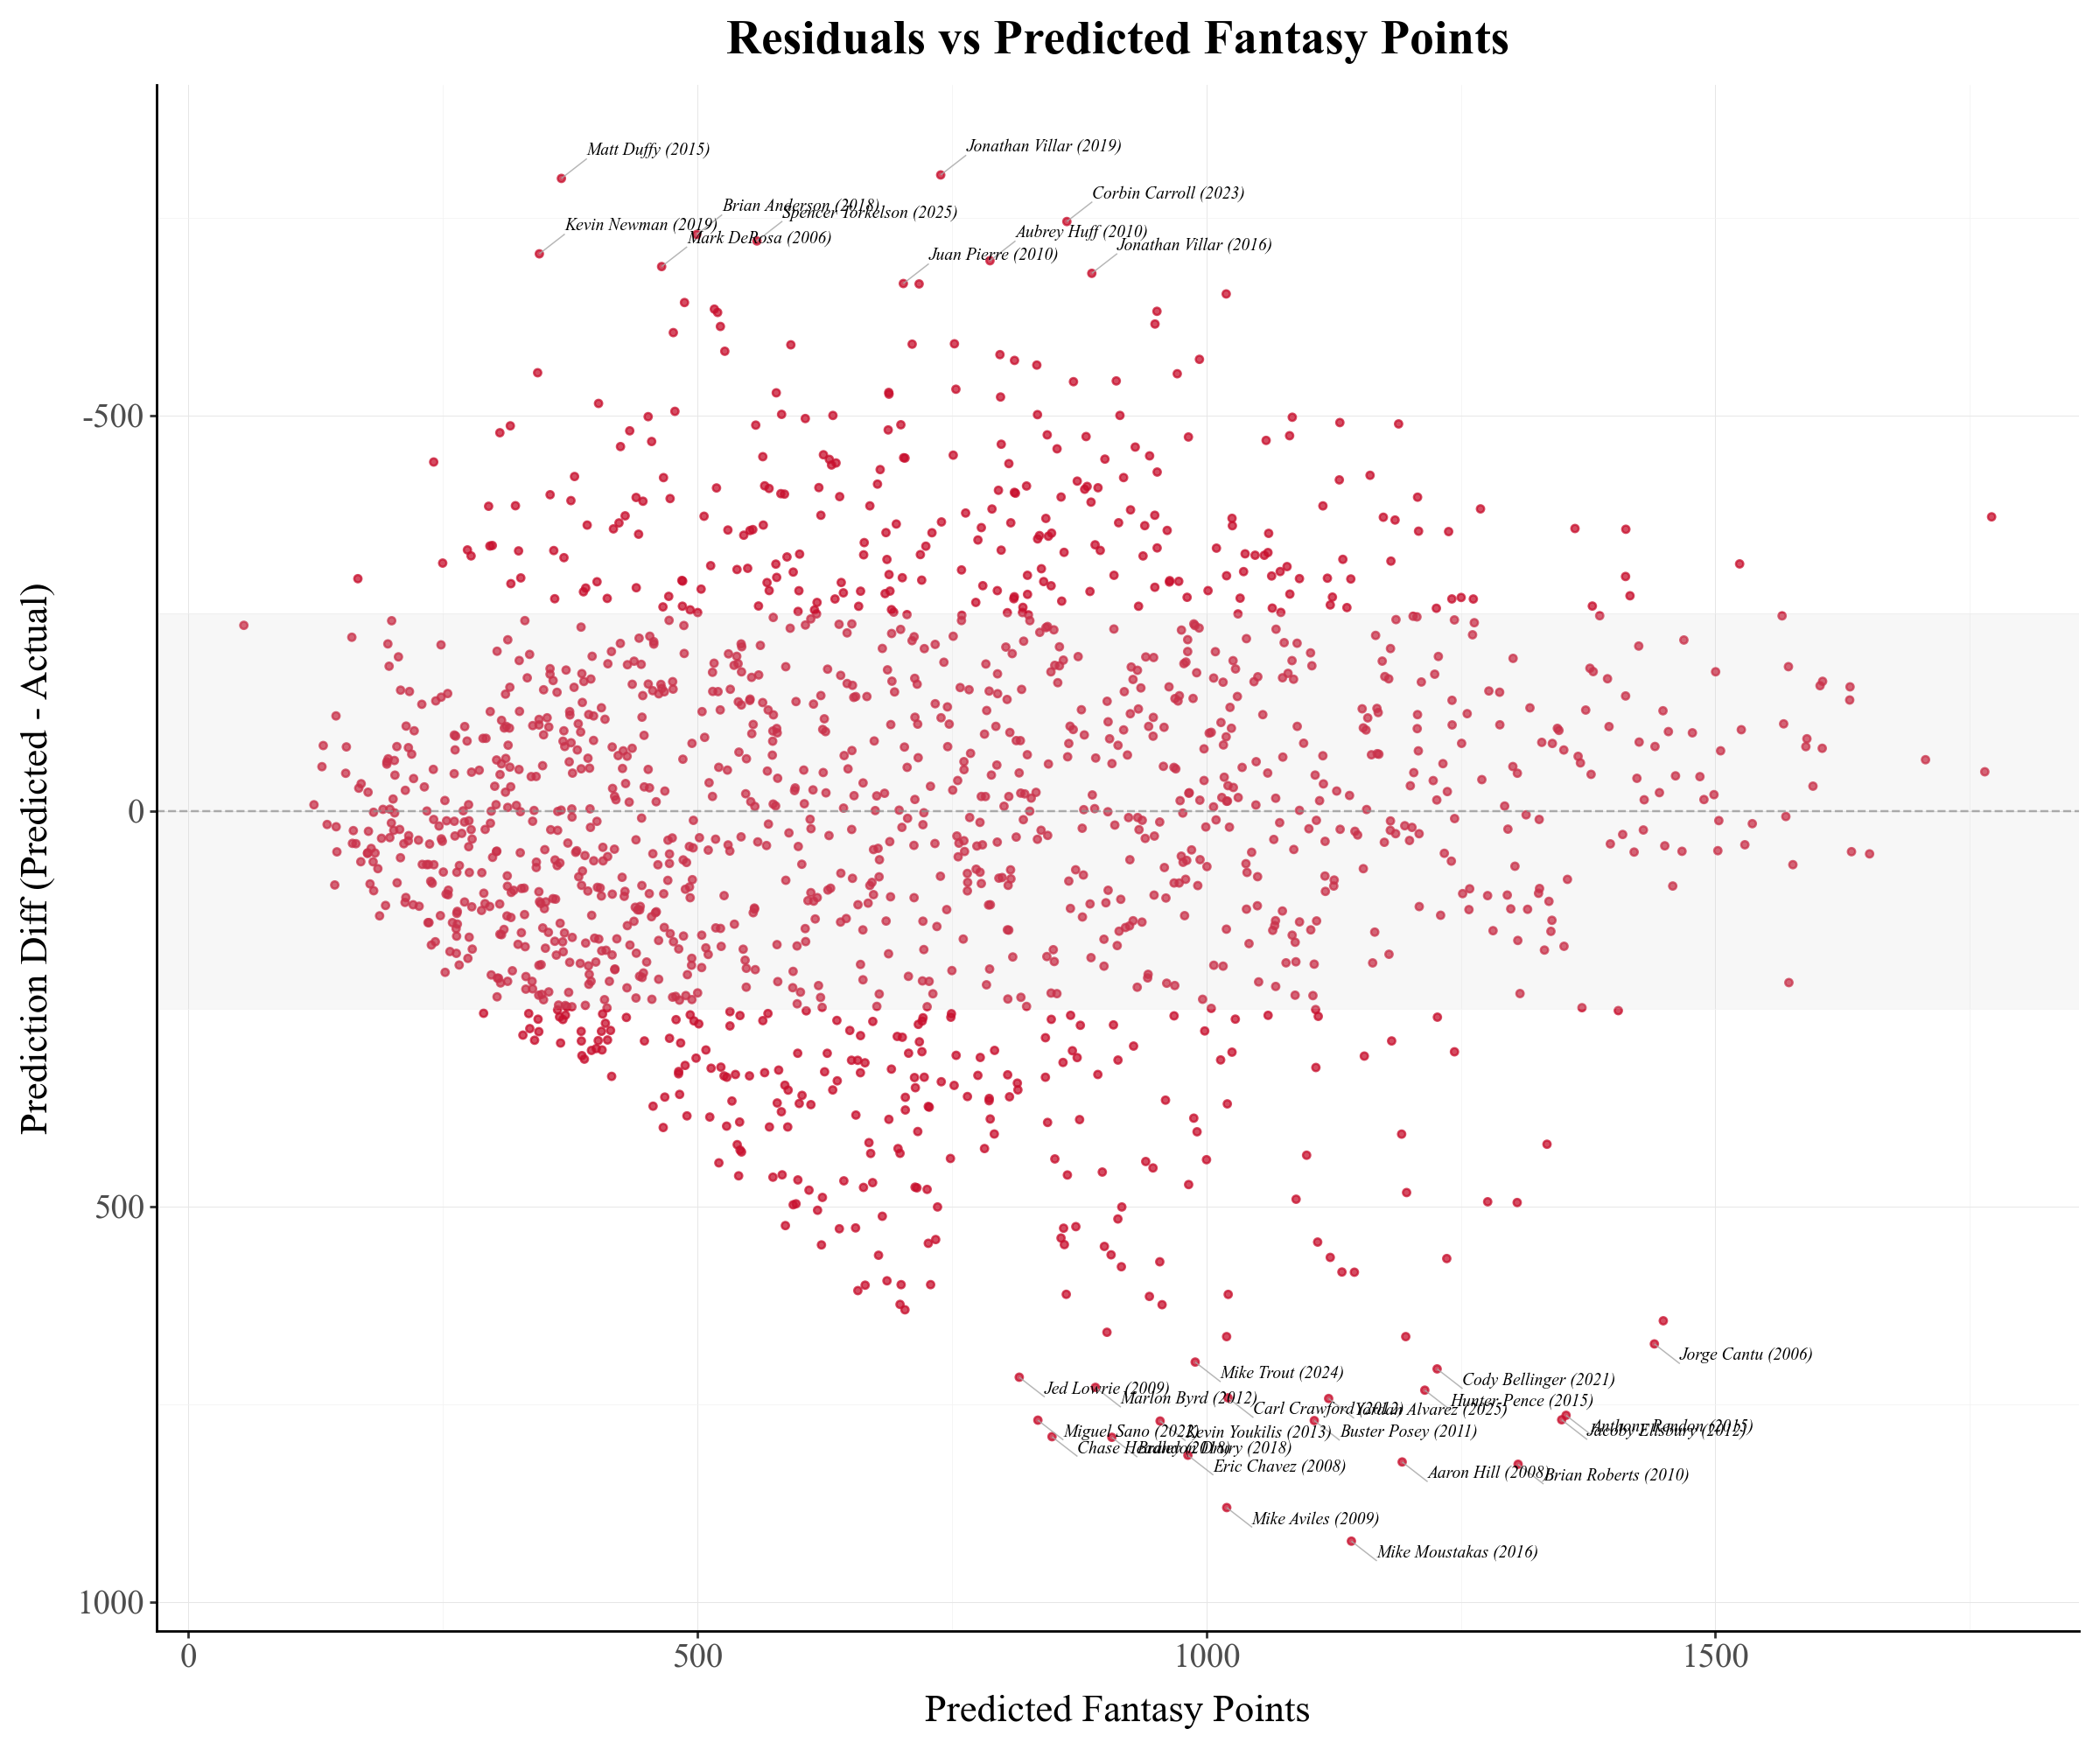

In [ ]:
p2 = plot_resid_vs_pred_mlb(
    batting_results,
    band=250,
    top_n=30,
    reverse_y=True,
    add_one_to_season_in_label=True,  # add 1 to season for labels to reflect predicted year
)
p2.show()

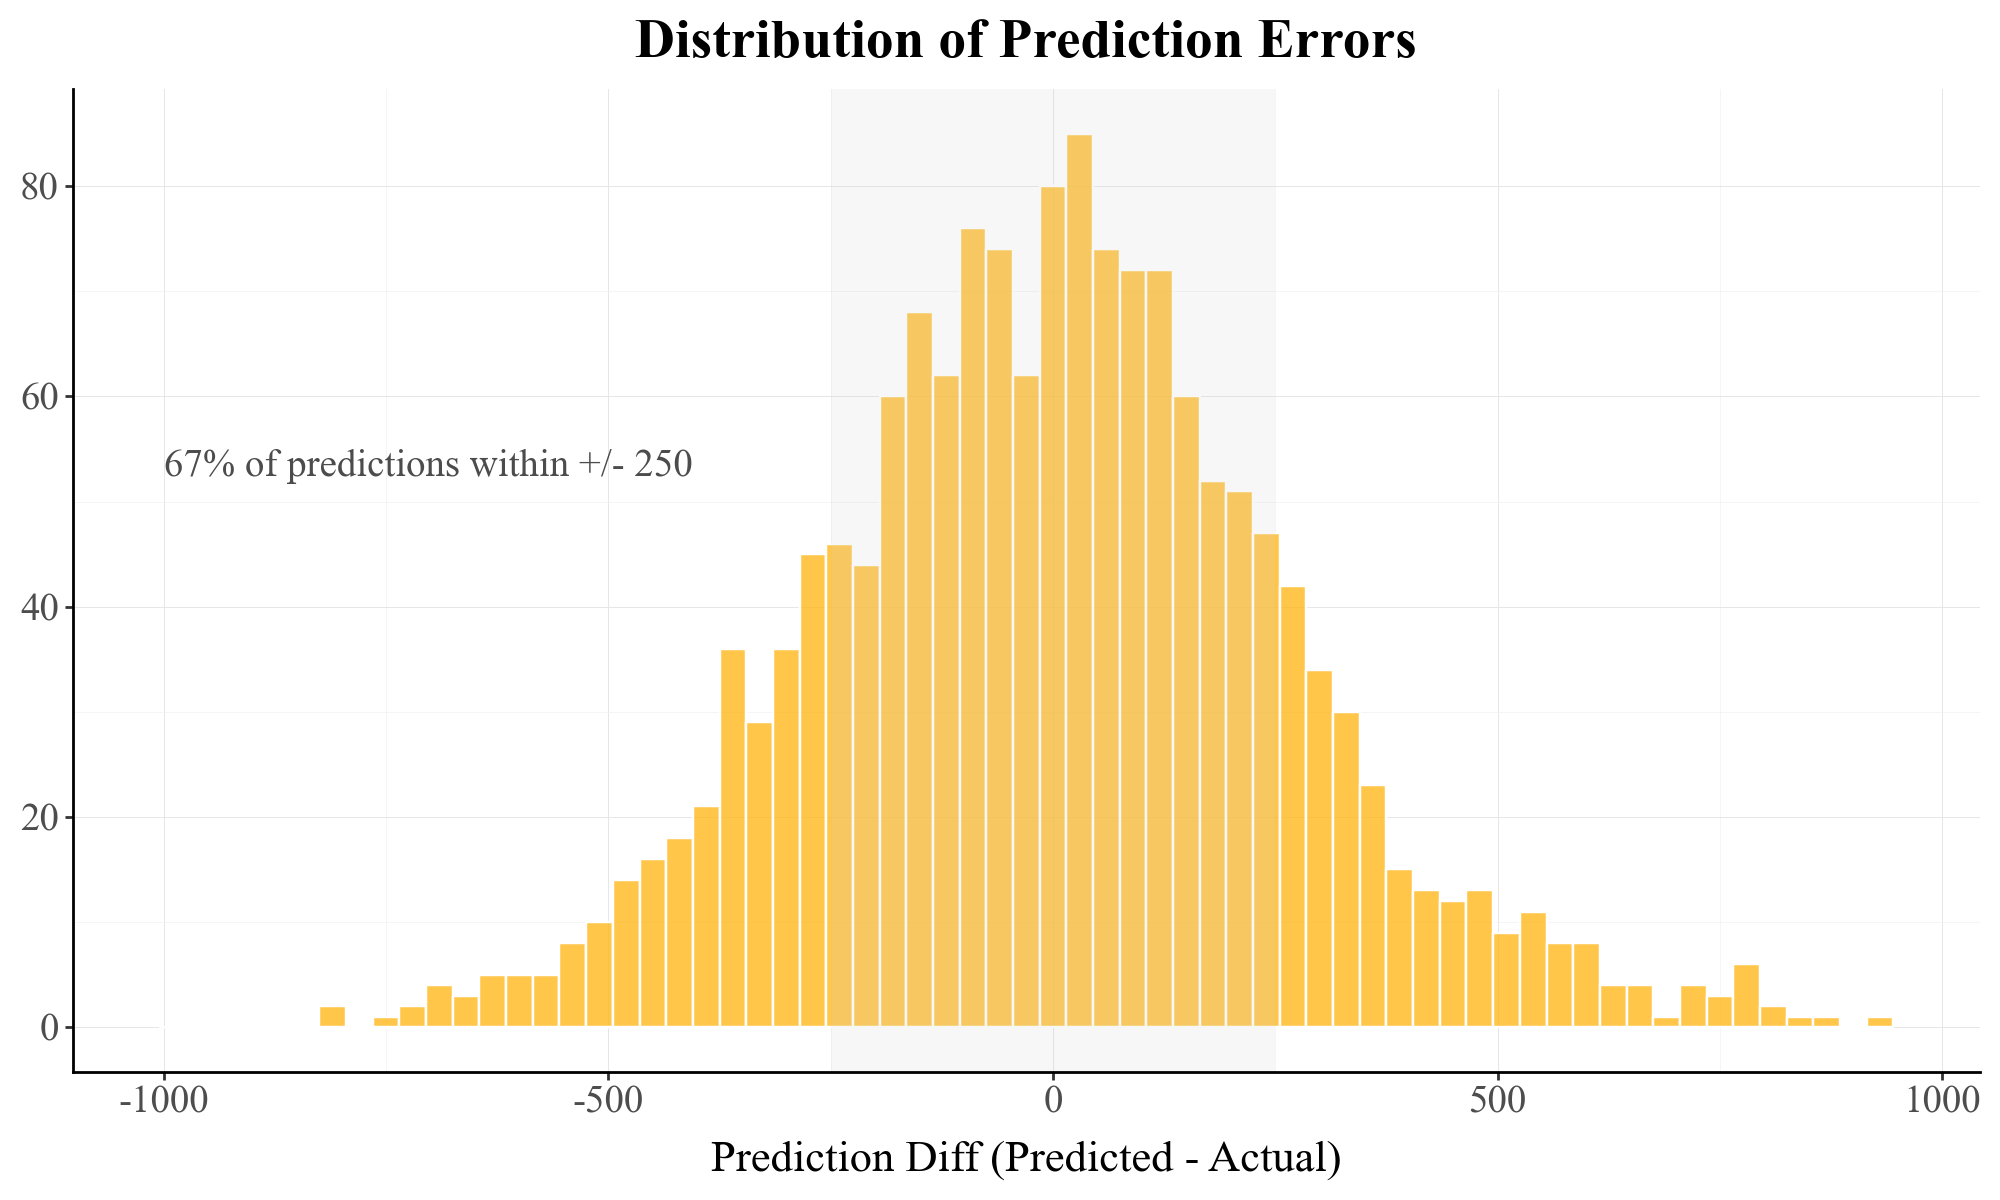

In [ ]:
p3 = plot_resid_hist_mlb(
    batting_results,
    band=250,
    binwidth=30,
    x_annotate=-1000,    # custom annotation position
    y_annotate=55,      # custom annotation position
)
p3.show()

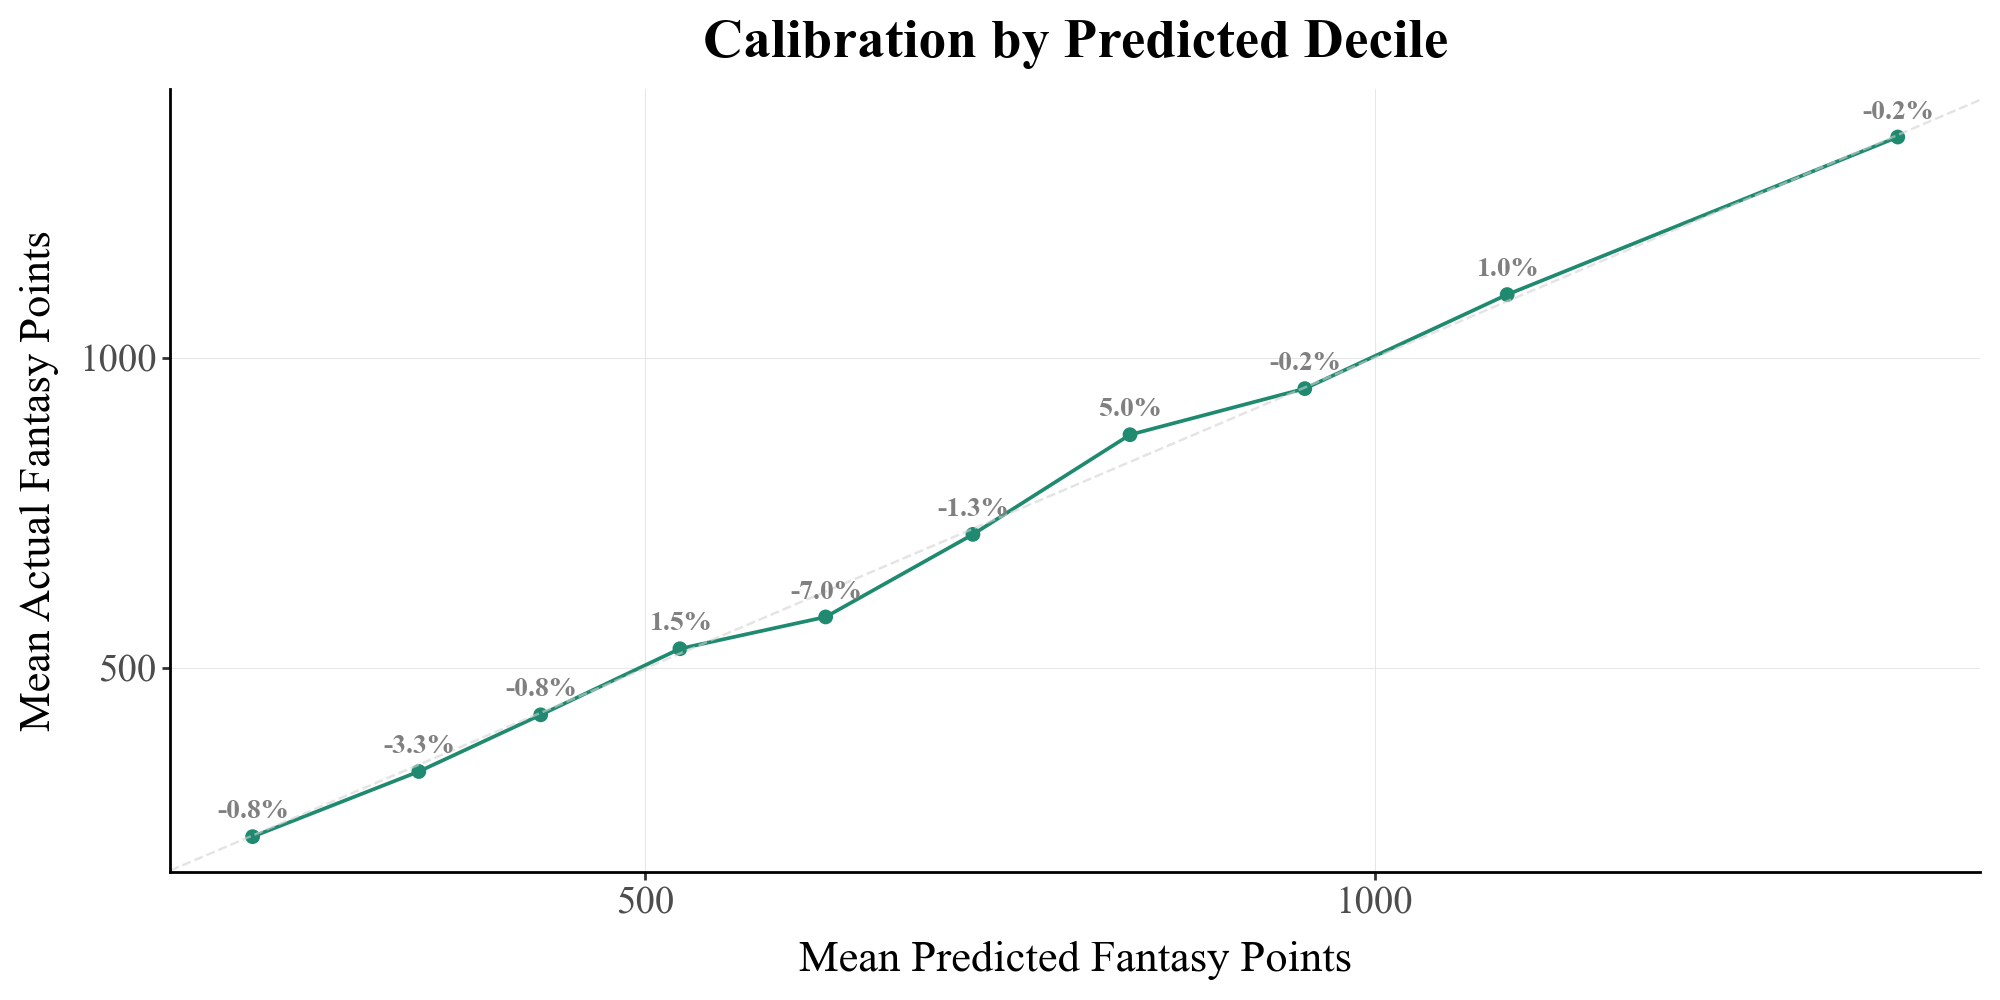

In [ ]:
p4 = plot_decile_calib(batting_results)
p4.show()

# Creating Pitching Model

# Creating baseline pitching predictions

In [ ]:
# Splitting data
x_train, x_val, x_test, y_train, y_val, y_test = split_data(pitching_df, random_state=753)

# Plotting data
model, y_pred = create_baseline(x_train.drop(columns=['IDfg']), x_val.drop(columns=['IDfg']), x_test.drop(columns=['IDfg']), 
                                            y_train, y_val, y_test)

[Test] RMSE: 177.158 | MAE: 129.259 | R^2: 0.600


In [ ]:
pitching_comp = compile_predictions(pitching_df, x_test, y_test, y_pred)
display(pitching_comp)

Name  fantasy_points_future  predicted_fantasy_points  \
1356     Max Scherzer                 1411.3               1279.693115   
864   Clayton Kershaw                 1246.6               1251.181152   
886   Felix Hernandez                 1113.3               1243.961792   
57    Clayton Kershaw                 1299.3               1242.851929   
641      Max Scherzer                 1464.6               1196.842529   
...               ...                    ...                       ...   
816       Javy Guerra                   63.6                 81.244415   
977      Eric Yardley                   27.6                 70.239563   
829    Ashton Goudeau                   65.3                 57.719578   
151     Jake Newberry                  113.0                 55.654621   
880       Cody Martin                   92.6                 30.108999   

      prediction_diff  absolute_diff  Season  Age  fantasy_points  
1356      -131.606885     131.606885    2015   30          1369.6  
864          4.581152       4.581152    2011   23          1371.3  
886        130.661792     130.661792    2012   26          1193.0  
57         -56.448071      56.448071    2013   25          1340.0  
641       -267.757471     267.757471    2017   32          1316.6  
...               ...            ...     ...  ...             ...  
816         17.644415      17.644415    2019   33           282.6  
977         42.639563      42.639563    2020   29           124.3  
829         -7.580422       7.580422    2021   28           130.3  
151        -57.345379      57.345379    2019   24           146.0  
880        -62.491001      62.491001    2015   25           100.6  

[1525 rows x 8 columns]

# Pitching Predictions

In [ ]:
# Tune model
best_params = tune_xgb(
    X_train=x_train,
    X_val=x_val,
    y_train=y_train,
    y_val=y_val,
    space=space,
    metric="rmse",     
    alpha=1.5,
    evals=50,
    random_state=42020,
    id_cols=["IDfg"],
    max_depth_choices=None,
)

# Generating prediction intervals via bootstrap-resampled models
pitching_intervals = generate_prediction_intervals(
    X_train=x_train,
    y_train=y_train,
    X_val=x_val,
    y_val=y_val,
    X_pred=pitching_pred.drop(columns=['fantasy_points_future']),
    base_params=best_params,
    n_bootstrap=35,
    random_state=202404,
    id_cols=['IDfg', 'Name'],
    n_estimators=1000,
    early_stopping_rounds=25,
)

100%|██████████| 50/50 [03:02<00:00,  3.65s/trial, best loss: 158.1479754995522]
Best Parameters: {'learning_rate': 0.03230093399216978, 'max_leaves': 24, 'grow_policy': 'lossguide', 'subsample': 0.9036809505233552, 'colsample_bytree': 0.7194095110228165, 'min_child_weight': 4.152298302447257, 'reg_lambda': 1.2025742978120342, 'reg_alpha': 0.007675668102603163, 'gamma': 0.002693974639523272}
[Best trial @ val] optimized=rmse | RMSE=158.148 | MAE=117.199 | ASYM=30996.935


In [ ]:
# Create final model
pitching_model, y_pred = create_model(
    X_train=x_train,
    X_val=x_val,
    X_test=x_test,
    y_train=y_train,
    y_val=y_val,
    y_test=y_test,
    final_params=best_params,
    random_state=4202022,
    id_cols=["IDfg"],
    alpha=1.5,               
)

Best iteration: 452
[Val] RMSE: 159.692 | MAE: 118.966 | R^2: 0.668 | ASYM: 31703.349
[Test] RMSE: 174.246 | MAE: 127.553 | R^2: 0.613 | ASYM: 37468.009


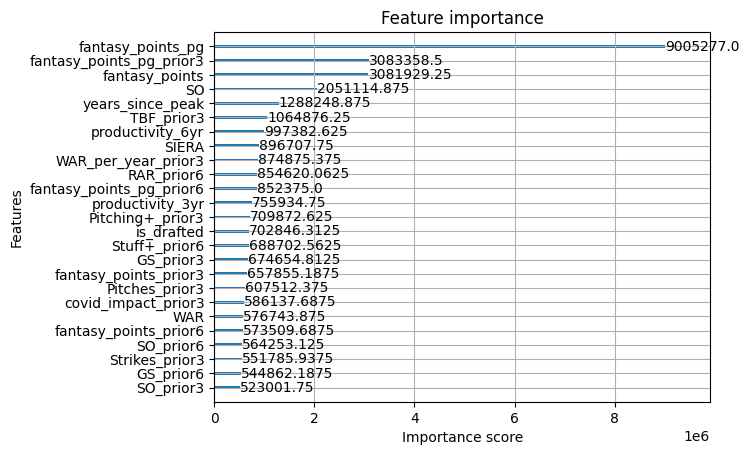

In [ ]:
# Plot feature importance using XGBoost's built-in method
plot_importance(pitching_model, importance_type="gain", max_num_features=25)
plt.show()

In [ ]:
pitching_results = compile_predictions(pitching_df, x_test, y_test, y_pred)
display(pitching_results)

Name  fantasy_points_future  predicted_fantasy_points  \
641       Max Scherzer                 1464.6               1308.329468   
864    Clayton Kershaw                 1246.6               1262.157471   
1356      Max Scherzer                 1411.3               1236.195435   
296   Justin Verlander                 1422.0               1227.030273   
130   Justin Verlander                 1167.3               1209.483643   
...                ...                    ...                       ...   
1146     Colten Brewer                  102.6                 70.231392   
151      Jake Newberry                  113.0                 63.258640   
425    Justin Nicolino                  151.0                 55.544815   
172      Taylor Clarke                  201.3                 51.459202   
1101       Koda Glover                   75.3                 44.631950   

      prediction_diff  absolute_diff  Season  Age  fantasy_points  
641       -156.270532     156.270532    2017   32          1316.6  
864         15.557471      15.557471    2011   23          1371.3  
1356      -175.104565     175.104565    2015   30          1369.6  
296       -194.969727     194.969727    2010   27          1167.3  
130         42.183643      42.183643    2009   26          1346.0  
...               ...            ...     ...  ...             ...  
1146       -32.368608      32.368608    2019   26           248.6  
151        -49.741360      49.741360    2019   24           146.0  
425        -95.455185      95.455185    2016   24           231.3  
172       -149.840798     149.840798    2019   26           331.6  
1101       -30.668050      30.668050    2016   23            82.6  

[1525 rows x 8 columns]

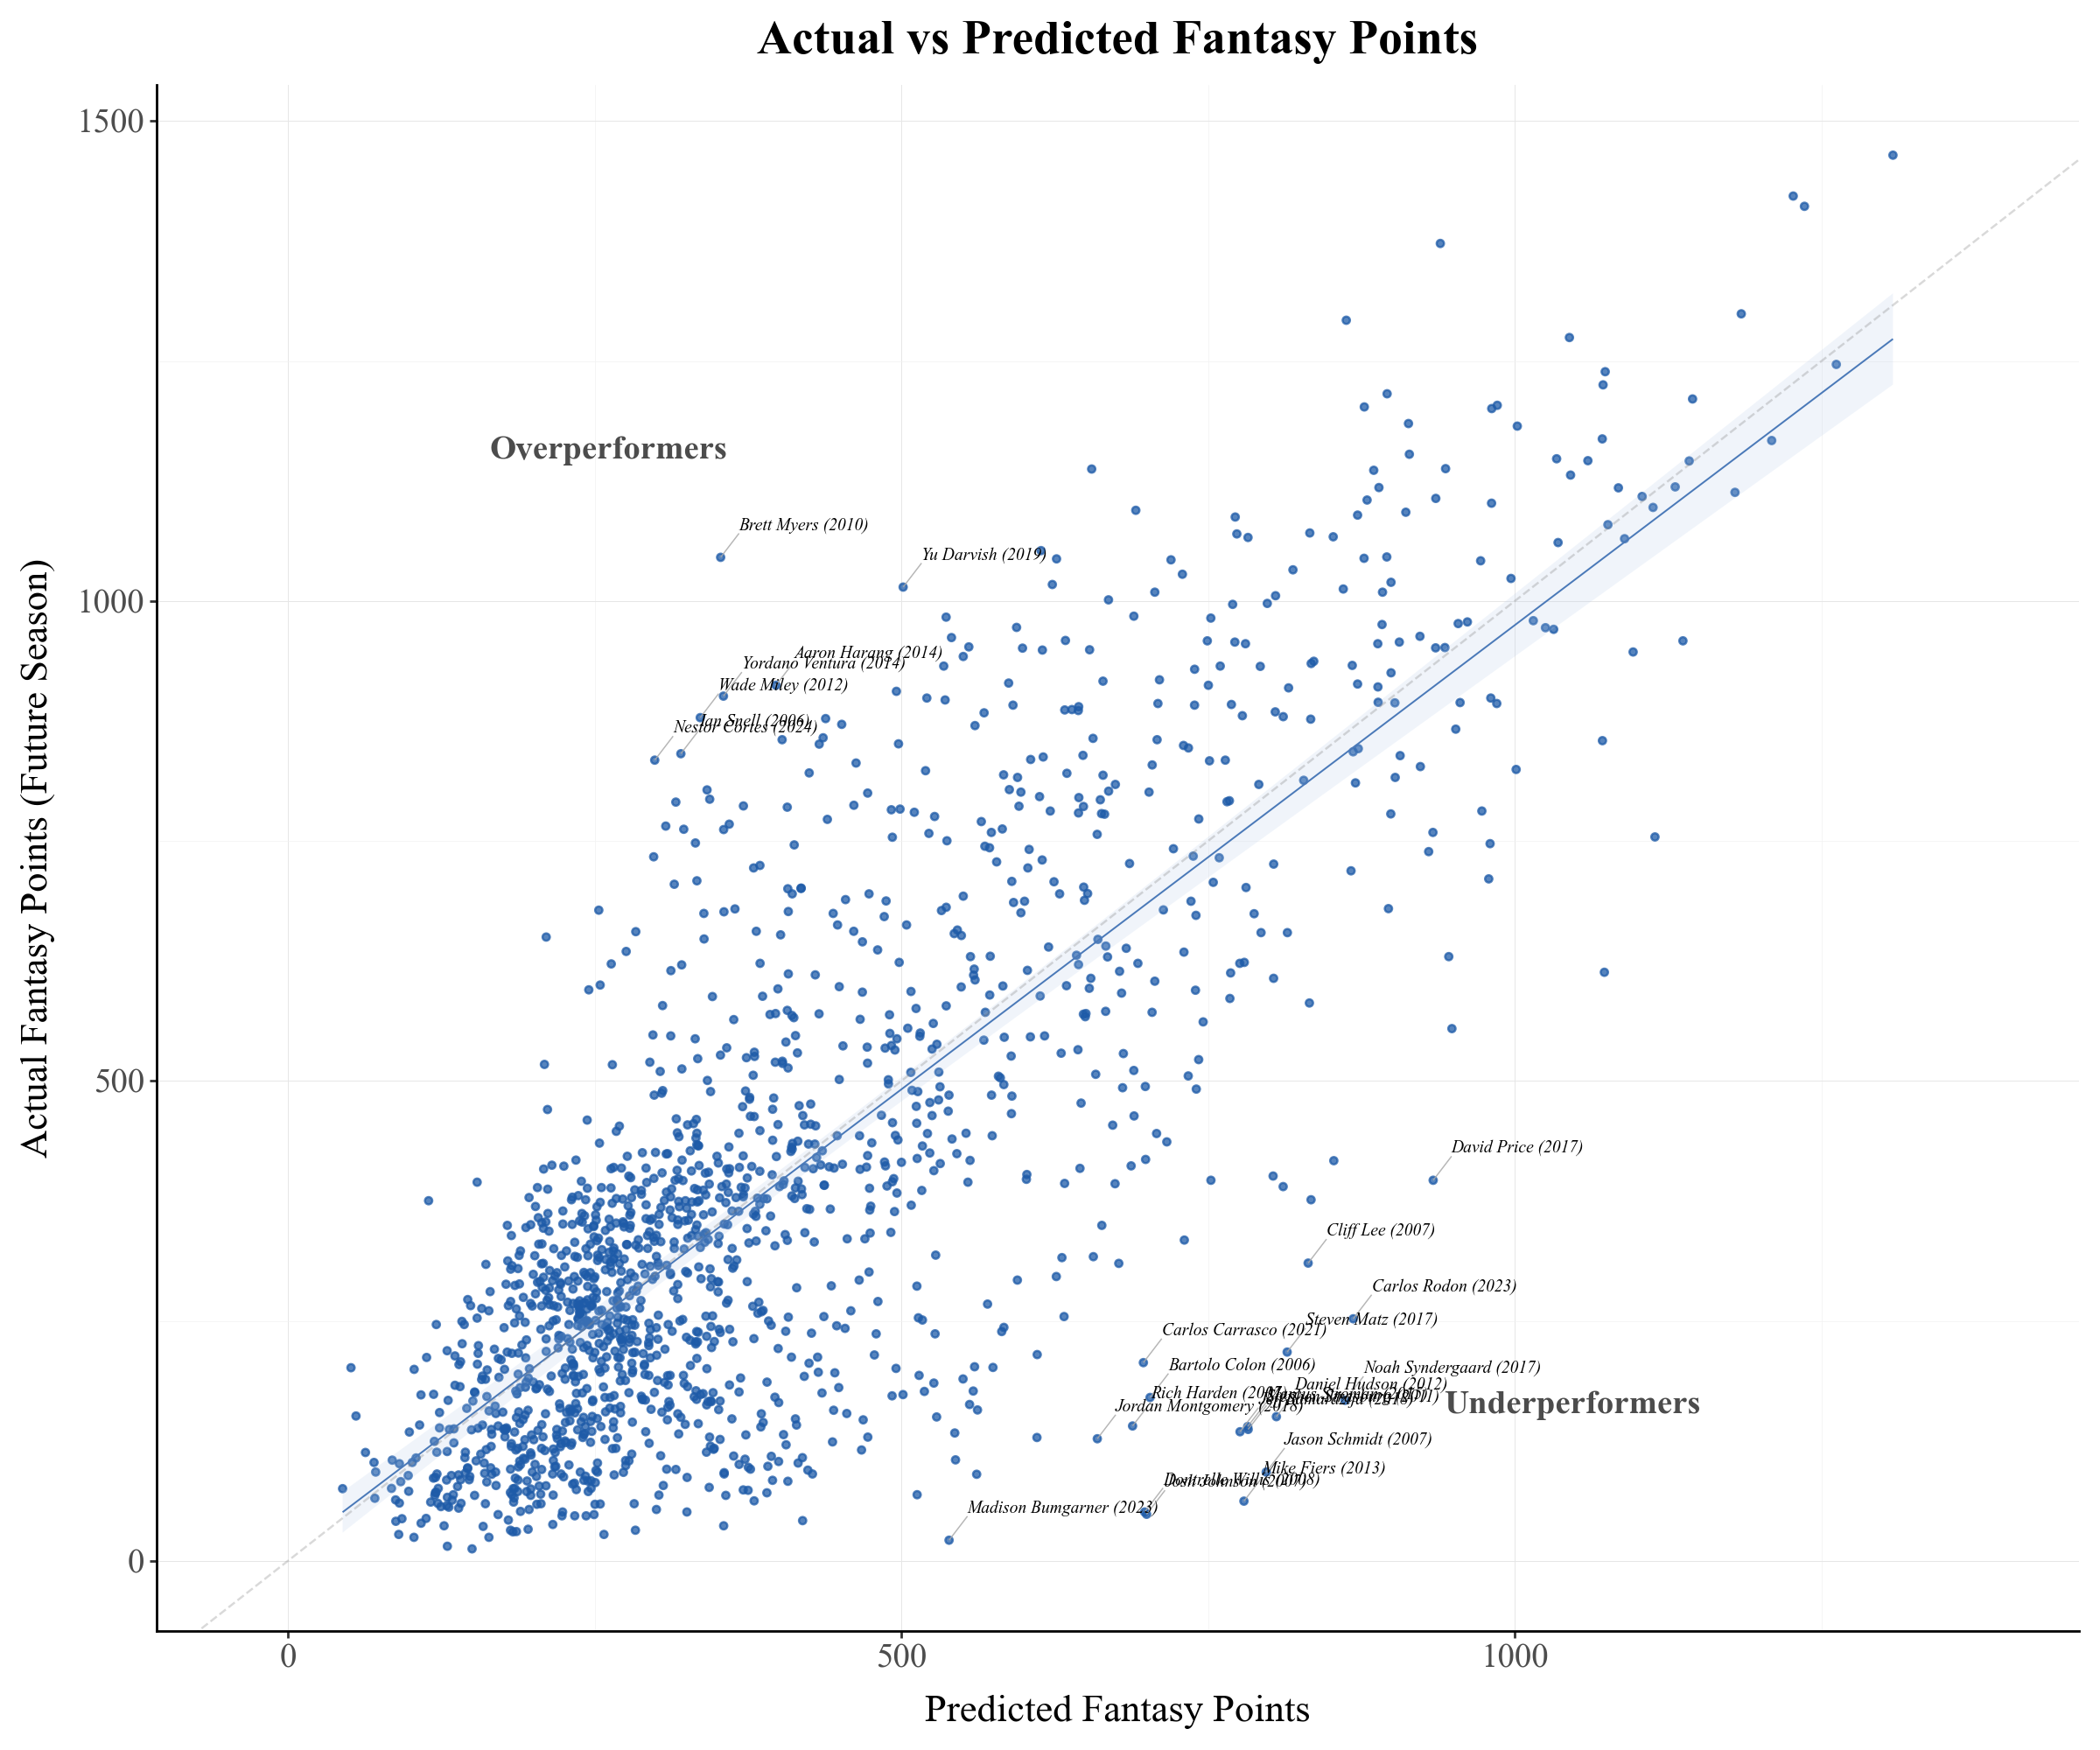

In [ ]:
p1 = plot_actual_vs_pred_mlb(
    pitching_results,
    top_n=25,
    x_offset=15,
    y_offset=25,
    add_one_to_season_in_label=True,  # add 1 to season for labels to reflect predicted year
)
p1.show()

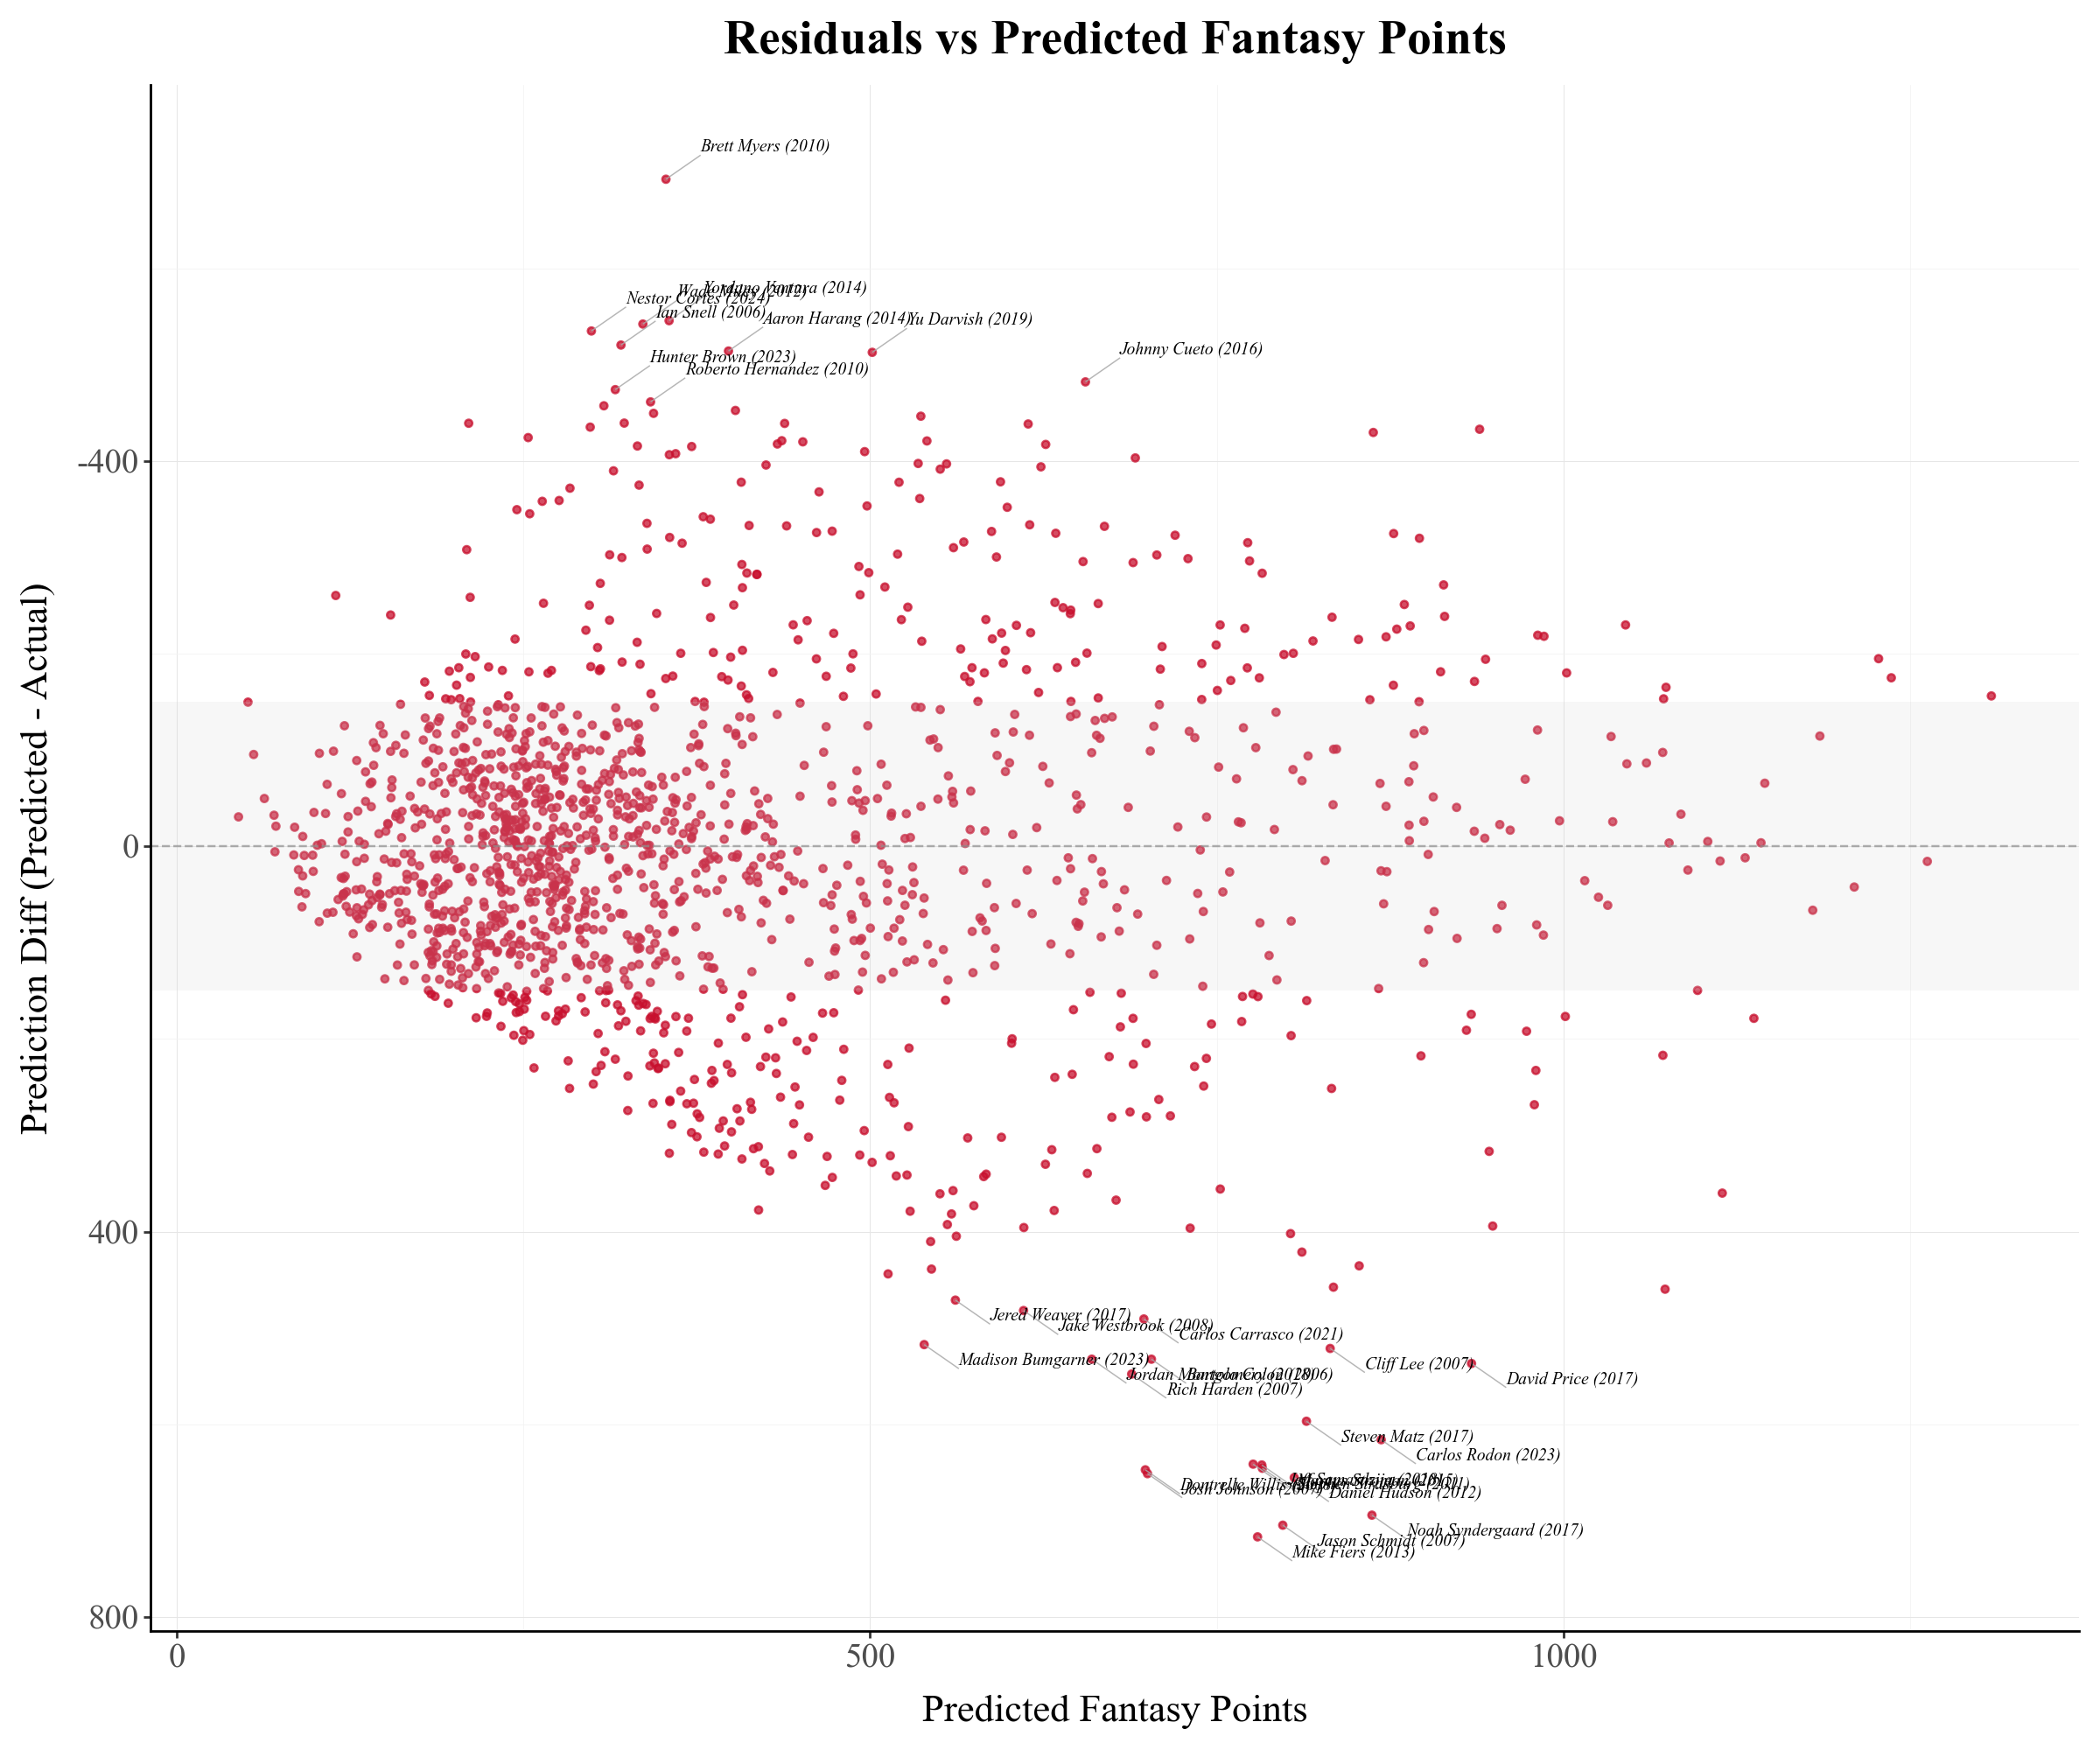

In [ ]:
p2 = plot_resid_vs_pred_mlb(
    pitching_results,
    band=150,
    top_n=30,
    reverse_y=True,
    add_one_to_season_in_label=True,  # add 1 to season for labels to reflect predicted year
)
p2.show()

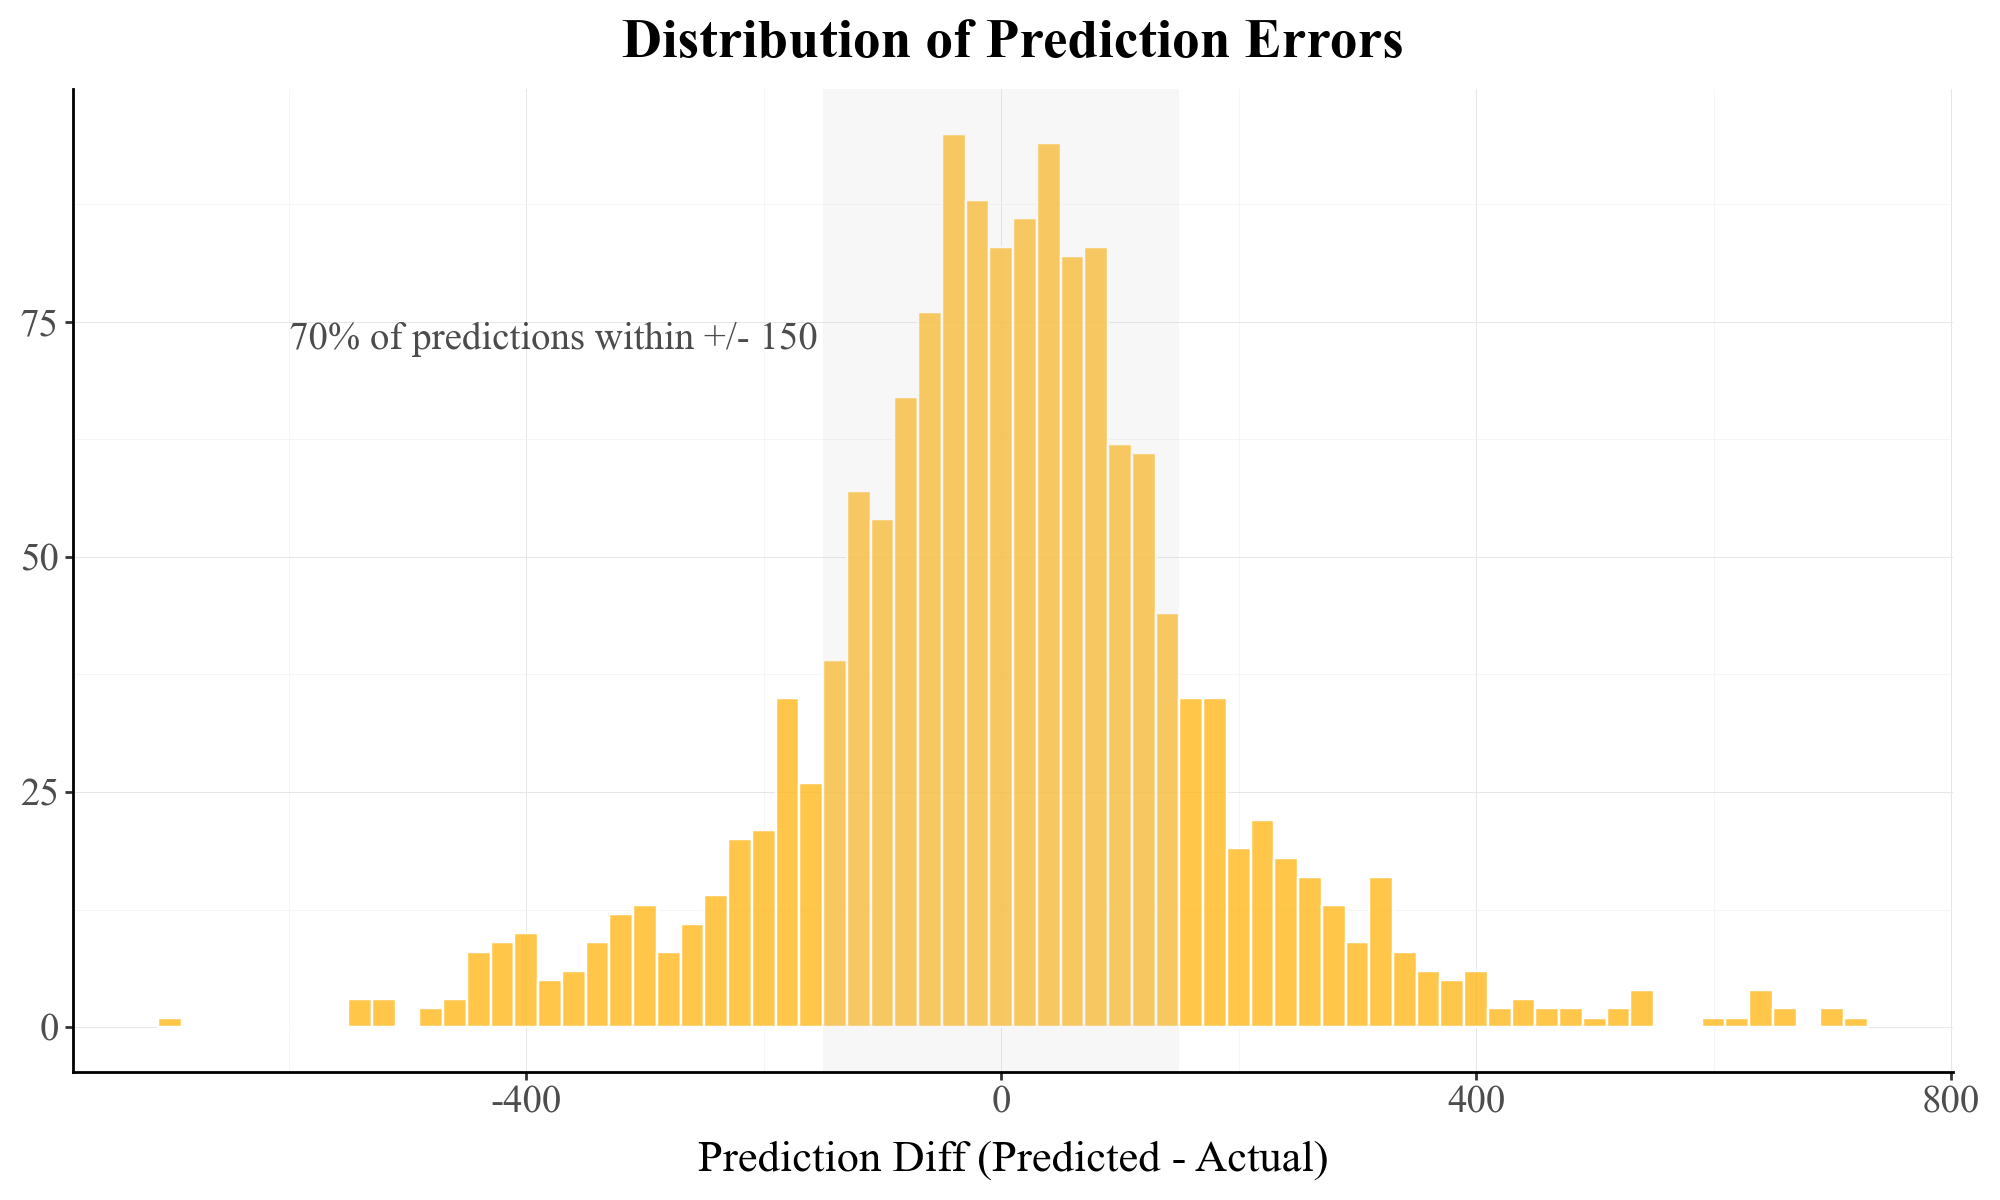

In [ ]:
p3 = plot_resid_hist_mlb(
    pitching_results,
    band=150,
    binwidth=20,
    x_annotate=-600,    # custom annotation position
    y_annotate=75,      # custom annotation position
)
p3.show()

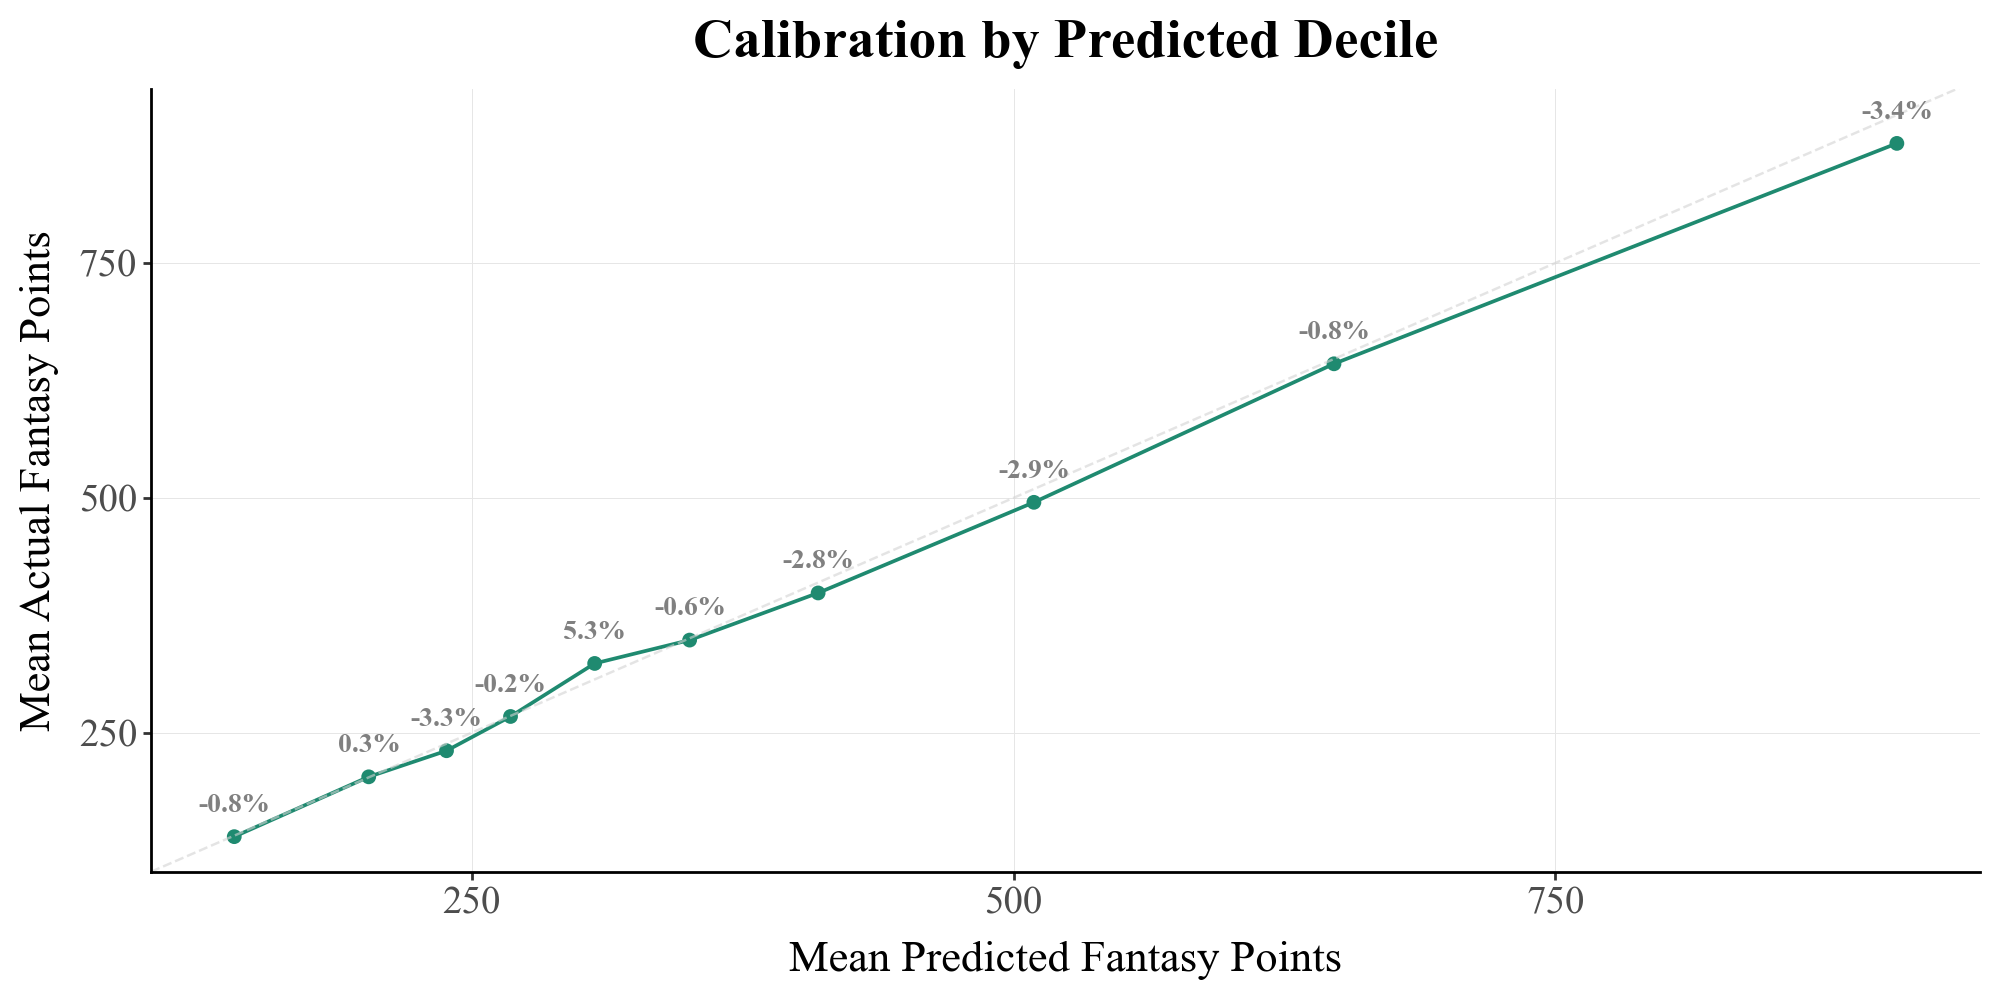

In [ ]:
p4 = plot_decile_calib(pitching_results)
p4.show()

# Predicting Upcoming Season Player Performance

In [ ]:
# Dropping fantasy_points_future from prediction dataframes
batting_pred = batting_pred.drop(columns=['fantasy_points_future'])
pitching_pred = pitching_pred.drop(columns=['fantasy_points_future'])

# Making predictions for the upcoming season
batting_pred['fantasy_points_pred'] = batting_model.predict(batting_pred.drop(columns=['IDfg', 'Name']))
pitching_pred['fantasy_points_pred'] = pitching_model.predict(pitching_pred.drop(columns=['IDfg', 'Name']))

# Merge intervals onto pred dataframes
batting_pred = batting_pred.merge(
    batting_intervals[['IDfg', 'pred_mean', 'pred_p10', 'pred_p50', 'pred_p90', 'pred_upside', 'pred_downside', 'implied_upside', 'pred_width_80']],
    on='IDfg',
    how='left'
)

pitching_pred = pitching_pred.merge(
    pitching_intervals[['IDfg', 'pred_mean', 'pred_p10', 'pred_p50', 'pred_p90', 'pred_upside', 'pred_downside', 'implied_upside', 'pred_width_80']],
    on='IDfg',
    how='left'
)

batting_pred.sort_values(by='fantasy_points_pred', ascending=False, inplace=True)
pitching_pred.sort_values(by='fantasy_points_pred', ascending=False, inplace=True)

In [ ]:
display(batting_pred)

IDfg  Season            Name  Age    G   AB    H   1B  2B  3B  ...  \
203  19755    2025   Shohei Ohtani   30  158  611  172   83  25   9  ...   
59   13510    2025    Jose Ramirez   32  158  593  168  101  34   3  ...   
228  20123    2025       Juan Soto   26  160  577  152   88  20   1  ...   
92   15640    2025     Aaron Judge   33  152  541  179   94  30   2  ...   
108  16478    2025  Kyle Schwarber   32  162  604  145   64  23   2  ...   
..     ...     ...             ...  ...  ...  ...  ...  ...  ..  ..  ...   
381  26143    2025   Troy Johnston   28   44  112   31   24   2   1  ...   
223  20002    2025   Bryce Johnson   29   55   76   26   21   4   0  ...   
485  30028    2025     Bob Seymour   26   26   78   16   13   1   1  ...   
352  25040    2025     Vinny Capra   28   47   96   12    9   2   0  ...   
357  25434    2025     Will Wilson   26   34   78   15   11   4   0  ...   

     player_tier_recent  fantasy_points_pred    pred_mean     pred_p10  \
203                star          1612.249023  1516.145142  1380.161621   
59                 star          1446.931030  1385.109985  1318.870117   
228                star          1434.462891  1428.764038  1233.208984   
92                 star          1419.806519  1380.577393  1217.636841   
108           above_avg          1416.723145  1249.152222  1026.937866   
..                  ...                  ...          ...          ...   
381         replacement           123.483284   175.559433   153.482117   
223         replacement           121.792587   173.860443   147.441788   
485         replacement           119.179680   179.196411   113.157021   
352         replacement           109.138611   160.117996   126.434265   
357         replacement            12.721123   116.772369    80.306503   

        pred_p50     pred_p90  pred_upside  pred_downside  implied_upside  \
203  1554.674194  1674.784424   158.639282     135.983521        1.049584   
59   1404.814819  1477.675903    92.565918      66.239868        1.155760   
228  1460.380249  1558.097046   129.333008     195.555054        0.616333   
92   1410.539429  1497.969116   117.391724     162.940552        0.664182   
108  1291.506348  1381.757080   132.604858     222.214355        0.564983   
..           ...          ...          ...            ...             ...   
381   170.803818   205.043808    29.484375      22.077316        1.237129   
223   173.202972   202.081390    28.220947      26.418655        1.002262   
485   174.628281   257.875031    78.678619      66.039391        1.159915   
352   151.193436   204.010757    43.892761      33.683731        1.243953   
357   121.669357   152.233292    35.460922      36.465866        0.942268   

     pred_width_80  
203     294.622803  
59      158.805786  
228     324.888062  
92      280.332275  
108     354.819214  
..             ...  
381      51.561691  
223      54.639603  
485     144.718018  
352      77.576492  
357      71.926788  

[537 rows x 215 columns]

In [ ]:
display(pitching_pred)

IDfg  Season              Name  Age   G  GS  Pitches  Strikes   W  WAR  \
186  17995    2025        Logan Webb   28  34  34     3282     2165  15  5.5   
195  18525    2025       Dylan Cease   29  32  32     3046     1925   8  3.4   
335  22267    2025      Tarik Skubal   28  31  31     2849     2003  13  6.6   
24   10310    2025      Zack Wheeler   35  24  24     2394     1549  10  4.0   
444  27463    2025   Garrett Crochet   26  32  32     3151     2114  18  5.8   
..     ...     ...               ...  ...  ..  ..      ...      ...  ..  ...   
484  27908    2025      Noah Murdock   26  14   0      392      237   1  0.0   
543  31552    2025        Zach Agnos   24  30   0      527      309   1 -0.4   
534  31184    2025     Luis Guerrero   24  13   0      289      166   0  0.0   
371  24203    2025      Luis Peralta   24  22   0      436      250   1 -0.7   
424  26203    2025  Andrew Saalfrank   27  28   0      427      271   2  0.5   

     ...  player_tier_recent  fantasy_points_pred   pred_mean    pred_p10  \
186  ...                star           934.858398  920.045776  850.973999   
195  ...           above_avg           925.631958  862.863037  792.129700   
335  ...                star           901.618347  897.554138  819.932800   
24   ...                star           872.842529  846.146179  742.933167   
444  ...           above_avg           854.801086  836.144348  763.962463   
..   ...                 ...                  ...         ...         ...   
484  ...         replacement            49.413116  107.797546   78.125122   
543  ...         replacement            46.644802   86.282524   67.450729   
534  ...         replacement            44.719620   85.058777   60.886826   
371  ...         replacement            42.382256   85.254807   60.553272   
424  ...         replacement            32.664177  102.838066   79.405090   

       pred_p50     pred_p90  pred_upside  pred_downside  implied_upside  \
186  915.822205  1000.931824    80.886047      69.071777        1.033394   
195  858.527222   941.457642    78.594604      70.733337        0.990331   
335  894.263672   994.215515    96.661377      77.621338        1.116222   
24   845.755310   932.513855    86.367676     103.213013        0.773388   
444  831.976318   925.895630    89.751282      72.181885        1.114323   
..          ...          ...          ...            ...             ...   
484  107.073830   134.674500    26.876953      29.672424        0.874036   
543   85.052559   109.501099    23.218575      18.831795        1.178930   
534   85.135803   105.868729    20.809952      24.171951        0.831648   
371   85.455345   104.075050    18.820244      24.701534        0.736487   
424  103.208290   124.771576    21.933510      23.432976        0.896660   

     pred_width_80  
186     149.957825  
195     149.327942  
335     174.282715  
24      189.580688  
444     161.933167  
..             ...  
484      56.549377  
543      42.050369  
534      44.981903  
371      43.521778  
424      45.366486  

[590 rows x 215 columns]

In [ ]:
batting_pred = split_name(batting_pred, 'Name')
pitching_pred = split_name(pitching_pred, 'Name')

In [ ]:
# Creating combined batting dataframe
batting_final = combine_projections(batting_pred, batting_projections)

Duplicate rows found:


IDfg  Season       Name   Age      G     AB     H    1B    2B   3B  \
450  13301.0  2025.0  Max Muncy  34.0  100.0  313.0  76.0  45.0  10.0  2.0   
451  13301.0  2025.0  Max Muncy  34.0  100.0  313.0  76.0  45.0  10.0  2.0   
452  29779.0  2025.0  Max Muncy  22.0   63.0  206.0  44.0  28.0   7.0  0.0   
453  29779.0  2025.0  Max Muncy  22.0   63.0  206.0  44.0  28.0   7.0  0.0   

     ...    pred_p90  pred_upside  pred_downside  implied_upside  \
450  ...  864.592712    84.637451      81.699585        0.945679   
451  ...  864.592712    84.637451      81.699585        0.945679   
452  ...  260.113556    26.245743      33.257660        0.737316   
453  ...  260.113556    26.245743      33.257660        0.737316   

     pred_width_80  first_name  last_name  Team  Positions  \
450     166.337036         max      muncy   LAD         3B   
451     166.337036         max      muncy   ATH   2B,3B,SS   
452      59.503403         max      muncy   LAD         3B   
453      59.503403         max      muncy   ATH   2B,3B,SS   

     projected_fantasy_points  
450                     884.0  
451                     665.0  
452                     884.0  
453                     665.0  

[4 rows x 220 columns]

In [ ]:
# Filter the batting_final DataFrame to drop rows where Name is "Max Muncy" and projected_fantasy_points < 750
batting_final = batting_final[~((batting_final['Name'] == 'Max Muncy') & (batting_final['projected_fantasy_points'] < 750))]

display(batting_final)

IDfg  Season            Name   Age      G     AB      H    1B    2B  \
0        NaN     NaN             NaN   NaN    NaN    NaN    NaN   NaN   NaN   
1    15640.0  2025.0     Aaron Judge  33.0  152.0  541.0  179.0  94.0  30.0   
2        NaN     NaN             NaN   NaN    NaN    NaN    NaN   NaN   NaN   
3        NaN     NaN             NaN   NaN    NaN    NaN    NaN   NaN   NaN   
4    19844.0  2025.0    Abraham Toro  28.0   77.0  259.0   62.0  42.0  13.0   
..       ...     ...             ...   ...    ...    ...    ...   ...   ...   
682  31562.0  2025.0    Zach Dezenzo  25.0   34.0   98.0   24.0  16.0   6.0   
683  19392.0  2025.0  Zach McKinstry  30.0  144.0  452.0  117.0  71.0  23.0   
684  31347.0  2025.0       Zach Neto  24.0  128.0  502.0  129.0  73.0  29.0   
685  29766.0  2025.0      Zack Gelof  25.0   30.0   92.0   16.0  11.0   3.0   
686  19562.0  2025.0      Zack Short  30.0   22.0   50.0   11.0   7.0   2.0   

       3B  ...     pred_p90  pred_upside  pred_downside  implied_upside  \
0     NaN  ...          NaN          NaN            NaN             NaN   
1     2.0  ...  1497.969116   117.391724     162.940552        0.664182   
2     NaN  ...          NaN          NaN            NaN             NaN   
3     NaN  ...          NaN          NaN            NaN             NaN   
4     0.0  ...   426.541473    43.231293      42.168304        0.939782   
..    ...  ...          ...          ...            ...             ...   
682   0.0  ...   198.596405    21.185272      18.609634        1.039322   
683  11.0  ...   664.296814    47.689758      42.482361        0.980294   
684   1.0  ...  1005.437561    65.167175      50.023621        1.096605   
685   0.0  ...   474.677246    59.741333      51.880341        1.066244   
686   0.0  ...   244.862656    31.171097      19.370941        1.449289   

     pred_width_80  first_name  last_name  Team    Positions  \
0              NaN        a.j.   vukovich   ARI        3B,LF   
1       280.332275       aaron      judge   NYY  LF,CF,RF,DH   
2              NaN       aaron     schunk   ATL     2B,3B,SS   
3              NaN    abimelec      ortiz   TEX        1B,OF   
4        85.399597     abraham       toro   NaN          NaN   
..             ...         ...        ...   ...          ...   
682      39.794907        zach    dezenzo   HOU        LF,RF   
683      90.172119        zach  mckinstry   DET  3B,SS,LF,RF   
684     115.190796        zach       neto   LAA           SS   
685     111.621674        zack      gelof   ATH           2B   
686      50.542038        zack      short   NaN          NaN   

     projected_fantasy_points  
0                        71.0  
1                      1748.0  
2                        64.0  
3                       104.0  
4                         NaN  
..                        ...  
682                     173.0  
683                     743.0  
684                    1314.0  
685                     220.0  
686                       NaN  

[685 rows x 220 columns]

In [ ]:
# Creating combined pitching dataframe
pitching_final = combine_projections(pitching_pred, pitching_projections)

No duplicate rows found.


In [ ]:
# # Filter the pitching_final DataFrame to drop rows where Name is Luis Garcia and position is not RP
# pitching_final = pitching_final[~((pitching_final['Name'].isin(['Luis Garcia'])) & (pitching_final['Positions'] != 'RP'))]

display(pitching_final)

IDfg  Season            Name   Age     G    GS  Pitches  Strikes  \
0    31764.0  2025.0   A.J. Blubaugh  24.0  11.0   3.0    508.0    316.0   
1        NaN     NaN             NaN   NaN   NaN   NaN      NaN      NaN   
2        NaN     NaN             NaN   NaN   NaN   NaN      NaN      NaN   
3        NaN     NaN             NaN   NaN   NaN   NaN      NaN      NaN   
4    23550.0  2025.0     Aaron Ashby  27.0  43.0   1.0   1033.0    645.0   
..       ...     ...             ...   ...   ...   ...      ...      ...   
891  20349.0  2025.0      Zack Kelly  30.0  28.0   0.0    583.0    383.0   
892  15823.0  2025.0    Zack Littell  29.0  32.0  32.0   2789.0   1868.0   
893  10310.0  2025.0    Zack Wheeler  35.0  24.0  24.0   2394.0   1549.0   
894  25703.0  2025.0        Zak Kent  27.0  12.0   0.0    308.0    187.0   
895  31827.0  2025.0  Zebby Matthews  25.0  16.0  16.0   1353.0    895.0   

        W  WAR  ...    pred_p90  pred_upside  pred_downside  implied_upside  \
0     3.0  0.1  ...  219.881226    34.105576      33.566177        0.962783   
1     NaN  NaN  ...         NaN          NaN            NaN             NaN   
2     NaN  NaN  ...         NaN          NaN            NaN             NaN   
3     NaN  NaN  ...         NaN          NaN            NaN             NaN   
4     5.0  1.2  ...  336.545502    18.200226      17.677338        0.872461   
..    ...  ...  ...         ...          ...            ...             ...   
891   1.0  0.4  ...  191.170929    11.038284      12.174408        0.789818   
892  10.0  1.5  ...  442.127106    37.825806      39.359924        0.871503   
893  10.0  4.0  ...  932.513855    86.367676     103.213013        0.773388   
894   1.0  0.1  ...  157.181488    37.904564      28.445503        1.278906   
895   5.0  1.4  ...  368.204407    46.917206      47.732147        0.920938   

     pred_width_80  first_name  last_name  Team  Positions  \
0        67.671753        a.j.   blubaugh   NaN        NaN   
1              NaN        a.j.     causey    KC          P   
2              NaN        a.j.     minter   NYM         RP   
3              NaN        a.j.        puk   ARI         RP   
4        35.877563       aaron      ashby   MIL         RP   
..             ...         ...        ...   ...        ...   
891      23.212692        zack      kelly   BOS      SP,RP   
892      77.185730        zack    littell   NaN         SP   
893     189.580688        zack    wheeler   PHI         SP   
894      66.350067         zak       kent   TEX         RP   
895      94.649353       zebby   matthews   MIN         SP   

     projected_fantasy_points  
0                         NaN  
1                        83.0  
2                       302.4  
3                       204.7  
4                       311.7  
..                        ...  
891                     247.5  
892                     707.3  
893                     729.6  
894                     192.4  
895                     600.2  

[896 rows x 220 columns]

In [ ]:
# Suppress the SettingWithCopyWarning while updating player names
pd.options.mode.chained_assignment = None  # default='warn'

In [ ]:
# Replace NaN values in the Name column with concatenation of first_name and last_name with first letters capitalized
batting_final['Name'] = batting_final.apply(
    lambda row: row['first_name'].capitalize() + ' ' + row['last_name'].capitalize() if pd.isna(row['Name']) else row['Name'],
    axis=1
)

# Selecting final relevant columns for predictions
batting_final = batting_final[['IDfg', 'Name', 'Age', 'Team', 'Positions', 'fantasy_points_pred', 'projected_fantasy_points',
                               'pred_downside', 'pred_upside', 'pred_width_80', 'implied_upside']]

# Replace NaN values in the "Positions" column with "DH" for hitters
batting_final['Positions'] = batting_final['Positions'].fillna('DH')

# Taking the first value in the Positions column as the player's primary position
batting_final['Positions'] = batting_final['Positions'].apply(get_value_before_comma)

# Replacing LF, CF, and RF positions with "OF" for alignment with standard rankings
batting_final['Positions'] = batting_final['Positions'].replace({'LF': 'OF', 'CF': 'OF', 'RF': 'OF'})

# Renaming Positions to Position
batting_final.rename(columns={'Positions': 'Position'}, inplace=True)

In [ ]:
# Replace NaN values in the Name column with concatenation of first_name and last_name with first letters capitalized
pitching_final['Name'] = pitching_final.apply(
    lambda row: row['first_name'].capitalize() + ' ' + row['last_name'].capitalize() if pd.isna(row['Name']) else row['Name'],
    axis=1
)

# Selecting final relevant columns for predictions
pitching_final = pitching_final[['IDfg', 'Name', 'Age', 'Team', 'Positions', 'fantasy_points_pred', 'projected_fantasy_points',
                               'pred_downside', 'pred_upside', 'pred_width_80', 'implied_upside']]

# Replace NaN values in the "Positions" column with "SP" for pitchers
pitching_final['Positions'] = pitching_final['Positions'].fillna('SP')

# Taking the first value in the Positions column as the player's primary position
pitching_final['Positions'] = pitching_final['Positions'].apply(get_value_before_comma)

# Renaming Positions to Position
pitching_final.rename(columns={'Positions': 'Position'}, inplace=True)

# Finalizing Predictions & Creating Relative Positional Value Scores

In [ ]:
# Replace NULL values in the prediction column with values from the projected column and vice versa
batting_final['fantasy_points_pred'] = batting_final['fantasy_points_pred'].fillna(batting_final['projected_fantasy_points'])
batting_final['projected_fantasy_points'] = batting_final['projected_fantasy_points'].fillna(batting_final['fantasy_points_pred'])

pitching_final['fantasy_points_pred'] = pitching_final['fantasy_points_pred'].fillna(pitching_final['projected_fantasy_points'])
pitching_final['projected_fantasy_points'] = pitching_final['projected_fantasy_points'].fillna(pitching_final['fantasy_points_pred'])

In [ ]:
# Adjusting positional group for select players within the batting_final dataframe to align with 2026 position designations
batting_final.loc[batting_final['Name'] == 'Shohei Ohtani', 'Position'] = 'OF'
batting_final.loc[batting_final['Name'] == 'Rafael Devers', 'Position'] = 'OF'
batting_final.loc[batting_final['Name'] == 'Tyler Soderstrom', 'Position'] = 'OF'

# Splitting batting players into infielders and outfielders
batting_final_if = batting_final[batting_final['Position'] != 'OF']
batting_final_of = batting_final[batting_final['Position'] == 'OF']

In [ ]:
# Creating final projected score, with 67% weight being placed on predictions and 33% weight being placed on fantasypros projections
# Creating initial player rankings based on final projection
batting_final_if['final_projection'] = (batting_final_if['fantasy_points_pred'] * MODEL_WEIGHT) + (batting_final_if['projected_fantasy_points'] * PROJECTION_WEIGHT)
batting_final_if['initial_rank'] = batting_final_if['final_projection'].rank(ascending=False)

batting_final_of['final_projection'] = (batting_final_of['fantasy_points_pred'] * MODEL_WEIGHT) + (batting_final_of['projected_fantasy_points'] * PROJECTION_WEIGHT)
batting_final_of['initial_rank'] = batting_final_of['final_projection'].rank(ascending=False)

pitching_final['final_projection'] = (pitching_final['fantasy_points_pred'] * MODEL_WEIGHT) + (pitching_final['projected_fantasy_points'] * PROJECTION_WEIGHT)
pitching_final['initial_rank'] = pitching_final['final_projection'].rank(ascending=False)

In [ ]:
player_pool = (ROSTER_SIZE * LEAGUE_SIZE) * BONUS_PLAYER_POOL_MULT
pitcher_pool = round(player_pool * PITCHER_SPLIT, 0)
batter_pool_if = round(player_pool * BATTER_SPLIT_IF, 0)
batter_pool_of = round(player_pool * BATTER_SPLIT_OF, 0)

In [ ]:
# Using player pool cutoffs to filter batting and pitching draft pool
batting_final_if = batting_final_if[batting_final_if['initial_rank'] <= batter_pool_if]
batting_final_of = batting_final_of[batting_final_of['initial_rank'] <= batter_pool_of]
pitching_final = pitching_final[pitching_final['initial_rank'] <= pitcher_pool]

In [ ]:
batting_final = pd.concat([batting_final_if, batting_final_of])

In [ ]:
batting_final = assign_position_group(batting_final, position_col = 'Position')

pitching_final = assign_position_group(pitching_final, position_col = 'Position')

In [ ]:
# Combine dataframes into a complete dataframe containing batters and hitters
combined_df = pd.concat([batting_final, pitching_final])

# Setting missing values in the implied_upside column to 1
combined_df['implied_upside'] = combined_df['implied_upside'].fillna(1)


In [ ]:
# Calculating relative positional values & ranking players within position based on projected value
value_df = calculate_relative_value(
    df=combined_df,
    position_col="position_group",
    projection_col="final_projection",
    vorp_cutoff=0.67,
    vorp_scale=1, # VORP scale set to 1, see validation within "estimate_vorp_scale.ipynb"
    dampening_map=POS_DAMPENING_MAP,
)

In [ ]:
# Saving value_df to CSV for vorp_scale estimation
# value_df.to_csv('notebooks/value_df.csv', index=False)

# Create Player Value Segments

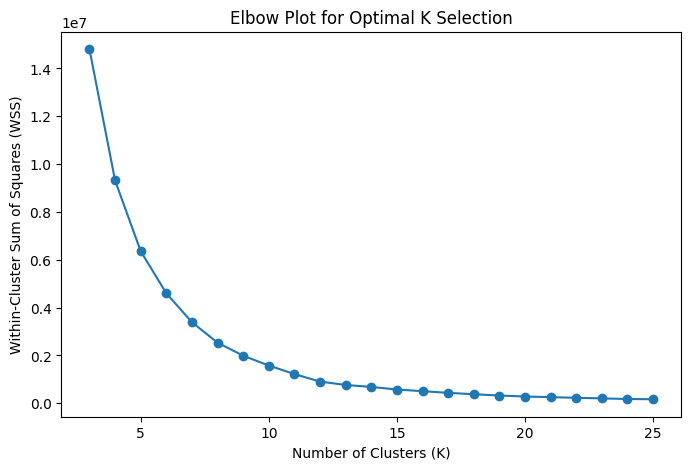

In [ ]:
# Evaluating clustering performance on varying K values
determine_optimal_k(value_df, max_k = 25)

In [ ]:
# Setting a K of 20 and placing players into relative value tiers
final_df = segment_players(value_df, k = 20)

In [ ]:
# Sorting final dataframe based on relative value, player value tier & position rank
final_df = final_df.sort_values(by = ['relative_value', 'player_value_tier', 'position_rank'], ascending = False)

# Selecting final columns for output
final_df = final_df[['Name', 'Age', 'Team', 'Position', 'position_group', 'fantasy_points_pred', 'projected_fantasy_points', 
                     'final_projection', 'pred_downside', 'pred_upside', 'implied_upside', 'relative_value',  
                     'overall_ranking', 'position_rank', 'player_value_tier']]

In [ ]:
final_df.to_csv(f'data/predictions_{datetime.now().strftime('%Y-%m-%d')}.csv', index=False)